# Algo testing on boat data
---

## Modules and options - Construct

In [ ]:
import pandas as pd
import numpy as np
import re
import calendar 
import pydoc
import types
import pickle
import random

import datetime as dt

import sys as sys
import os as os
import operator as operator
from shutil import copyfile
from collections import Counter
import time as time

print ("Running system under path: {}\n".format(sys.prefix))

print ("System version: {}".format(sys.version))
print ("Pandas version: {}".format(pd.__version__))
print ("Numpy version: {}".format(np.__version__))
print ("\n")

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

# Load reference look-up table into Oracle Exa DB;
# sys.path.append("/nfshome/patblo/workspace/utils")
# import nn_data_src as nn
# import pandas.io.sql as psql

# Construct
sys.path.append("/nfshome/patblo/code/")

import Construct_Py36 as cstr

## Modules and options - Spear

In [ ]:
from sklearn import preprocessing
from sklearn import linear_model
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, AdaBoostClassifier, ExtraTreesClassifier, RandomForestRegressor
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble.partial_dependence import plot_partial_dependence
from sklearn.naive_bayes import GaussianNB

from sklearn.model_selection import GridSearchCV, learning_curve, ShuffleSplit, RandomizedSearchCV, train_test_split, cross_val_score, cross_validate,validation_curve, KFold

from sklearn.preprocessing import PolynomialFeatures, StandardScaler, LabelEncoder

from sklearn.feature_selection import RFE,SelectKBest, f_classif

from sklearn.metrics import roc_curve, auc, classification_report, confusion_matrix, accuracy_score, roc_auc_score, mean_squared_error

from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import _name_estimators

from sklearn.externals import joblib
from sklearn.externals import six

from sklearn.base import BaseEstimator
from sklearn.base import ClassifierMixin
from sklearn.base import clone
from sklearn.base import TransformerMixin

from mlxtend.classifier import StackingCVClassifier

import operator
import lightgbm as lgbm
import xgboost as xgboost

import Spear_Py36 as spr

In [ ]:
# Widen notebook
from IPython.core.display import HTML
HTML("<style>.container { width:85% !important; }</style>")

In [ ]:
pd.set_option('display.max_columns', 500)
pd.set_option('display.expand_frame_repr', False)

## Time

In [2007]:
from dateutil import relativedelta as rtd
from datetime import datetime, timedelta, date

#--------------------------------- 
# TIME DIMENSIONS
#---------------------------------
def f_this_ym():
    return dt.date.today().strftime('%Y%m')

def f_last_ym():
    return (dt.date.today() - rtd.relativedelta(months=+1)).strftime("%Y%m")

def f_last_ymd_01():
    return (dt.date.today() - rtd.relativedelta(months=+1)  - rtd.relativedelta(day=1)).strftime("%Y%m%d")

def f_t_now():
    return dt.datetime.today().strftime("%H:%M:%S")

def f_d_now():
    return dt.date.today().strftime("%Y-%m-%d")

def f_dt_now():
    return dt.datetime.today().strftime("%Y-%m-%d %H:%M:%S")


In [2008]:
# Base functions imported in order to get methods get_params() and set_params() to return classifiers parameters as well as using the score method
from sklearn.base import BaseEstimator
from sklearn.base import ClassifierMixin

from sklearn.preprocessing import LabelEncoder
from sklearn.externals import six
from sklearn.base import clone
from sklearn.pipeline import _name_estimators
import operator


class MajorityVoteClassifier(BaseEstimator
                            ,ClassifierMixin):
    
    
    """
    A majority vote ensamble classifier
    
    Parameters:
    
    classifiers          array-like, integer, shape=[n_classifiers]: Different classifiers for the ensamble
    vote                 str, {'classlabel', 'probability'}: Default 'probability'. If 'classlabel' the prediction is based on the argmax of class labels. Else if
                                                             'probability', the argmax of the sum of the probabilities is used to predict the class label (use for calibrated classifiers)
    weights              array-like, float, shape=[n_classifiers]: Optional, default=None. If a list of integers or floats are provided, the classifiers are weighted by importance.
                                                                     Uses uniform weight if weights=None.
        
    """
    
    def __init__(self
                ,classifiers
                ,vote='classlabel'
                ,weights=None):
        
        self.classifiers=classifiers
        self.names_classifiers={key: value for key, value in _name_estimators(classifiers)}
        self.vote=vote
        self.weights=weights
        
    def fit(self
           ,X
           ,y):
        
        """
        Fit classifier
        
        Parameters:
                
        X        integers: {Array-like}, shape=[n_samples, n_features]
                           Training vector, where n_samples is number of samples(rows) and n_features is number of features(columns) 
                         
        y        integers: Array-like, shape=[n_samples]
                           Target values
                           
        Returns:
        
        self      Object
        
        """        
        
        # Use LabelEncoder to ensure that class labels start with 0 which is of importance for np.argmax
        # Call in self.predict
        
        self.labelenc_=LabelEncoder()
        self.labelenc_.fit(y)
        self.classes_=self.labelenc_.classes_
        
        self.classifiers_=[]
        
        for clf in self.classifiers:
            fitted_clf=clone(clf).fit(X, self.labelenc_.transform(y))
            self.classifiers_.append(fitted_clf)
            
        return self
            
            
            
    def predict(self
               ,X):
        
        
        """
        
        Assign a class label through majority vote.
        
        Paramters:
        
        X               Array-like, sparse matrix, integer/float. Shape=[n_rows, n_features]: Matrix of training sample
        
        Returns:
        
        maj_vote        array-like, shape=[n_samples]: Predicted class labels from the ensamble  
        
        """
        
        if self.vote == 'probability':
            maj_vote=np.argmax(self.predict_proba(X)
                                ,axis=1)
            
        # CLass label vote
        else:
            
            # Collects result from clf.predict calls
            predictions=np.asarray([clf.predict(X) for clf in self.classifiers_]).T
            
            maj_vote=np.apply_along_axis(lambda x: np.argmax(np.bincount(x
                                                                           ,weights=self.weights
                                                                          )
                                                              )
                                                                ,axis=1
                                                                ,arr=predictions
                                          )
            
            maj_vote=self.labelenc_.inverse_transform(maj_vote)
            
            return maj_vote
        
    
    def predict_proba(self
                     ,X):
        
        """
        
        Predict (score) probabilities for class labels through majority vote.
        
        Parameters:
        
        X               Array-like, sparse matrix, integer/float. Shape=[n_rows, n_features]: Training vector where n_rows is number of sample and n_features is dimensionality of explanatory features
        
        Returns:
        
        avg_proba       array-like, float, shape=[n_sample, n_classes]: Weighted average probability for each class per sample
        
        """ 
        
        probas=np.asarray([clf.predict_proba(X) for clf in self.classifiers_])
        
        avg_probas=np.average(probas
                               ,axis=0
                               ,weights=self.weights
                               )
        
        return avg_probas
    
    def get_params(self
                  ,deep=True):
        
        """ 
        
        Get classifier parameter names for the GridSearch.
        
        """
        
        if not deep:
            return super(MajorityVoteClassifier
                        ,self).get_params(deep=False)
        
        else:
            out=self.names_classifiers.copy()
            
            for name, step in six.iteritems(self.named_classfiers):
                for key, value in six.iteritems(step.get_params(deep=True)):
                    out['%s__%s' % (name, key)]=value
                    
            return out
        
        
    


In [2009]:
# Create a class to select numerical or categorical columns 
# since Scikit-Learn doesn't handle DataFrames yet
class c_DataFrameToMatrix(BaseEstimator, TransformerMixin):
    
    def __init__(self, feat_names, all_feat = True):
        self.feat_names = feat_names
        self.all_feat = all_feat
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        
        # We take the whole data frame and ship it back as a matrix
        if self.all_feat:
            return X.values.astype('float64')
        
        # feat names exist, ship back a subset of data as matrix
        elif not self.all_feat and self.feat_names:
            return X[self.feat_names].values.astype('float64')

In [2010]:
def NoRun():
    np.random.seed(1234)

    X_test=df_train_final.values
    feat_test=df_train[[col for col in list_col_inp_feat if col=='inp_grp_age_int']].sample(frac=0.25).reset_index(drop=True).values

    print ("Shape of design matrix: {}".format(X_test.shape))
    display(X_test[:5])

    print ("Shape of feature array: {}".format(feat_test.shape))
    display(feat_test[:5])

    X_test_conc=np.concatenate((X_test,list(feat_test)),axis=1)

    print ("Shape of concatenated design matrix: {}".format(X_test_conc.shape))
    display(X_test_conc[:5])

In [2231]:
#-------------------------------------
# Weight of Evidence (WoE) functions
#-------------------------------------

# Define function for estimating WoE for a discrete variable
def f_woe(exec_f, indata, list_col_woe, dict_woe_summary):
    
    """
    This function maps WoE values to a discrete ordinal or nominal categorical variable. The function also pushes back a "long form" table containing all categorical features, their
    respective values, adherent WoE values and IV values. Finally, the function return an aggregated IV table where one can do EDA to review predictive strength of the inididual 
    feature with respect to target variable.
    
    NOTE:
    
    Count variable needs to be named 'id', target variable needs to be named 'target'.
    """

    if exec_f:
    
        df_tmp=indata.copy()
        
        
        
        #-----------------------------------------------
        # One input feature to calculate WoE and IV for
        #-----------------------------------------------
        if len(list_col_woe)==1:
        
            # Aggregate discrete variable and calculate metrics
            df_woe=cstr.f_grpby_aug(True, df_tmp, list_col_woe, dict_woe_summary).rename(columns={'count':'N'
                                                                                                  ,'target_sum':'target_1'
                                                                                                 ,list_col_woe[0]:'var_lvls'})
            
            df_woe['var_name']=list_col_woe[0]

        #-----------------------------------------------
        # Mor ethan one feature, we create consolidated 
        # aggregation tables for WoE and IV 
        #-----------------------------------------------
        else:
                    
            list_tmp_hld_woe=list()
        
            # Itterate over features requiring WoE and IV calculation
            for idx_col_woe, col_woe in enumerate(list_col_woe):
                
                print ("Commencing calculation of WoE and IV for variable: {}".format(col_woe))
               
                # Aggregate discrete variable and calculate metrics
                df_tmp_woe=cstr.f_grpby_aug(True, df_tmp, [col_woe], dict_woe_summary).rename(columns={'count':'N'
                                                                                            ,'target_sum':'target_1'
                                                                                            ,col_woe:'var_lvls'})                
                
                df_tmp_woe['var_name']=col_woe
                
                # Common holder
                list_tmp_hld_woe.append(df_tmp_woe)
                
            # Concat to common woe
            df_woe=pd.concat(list_tmp_hld_woe, axis=0)

        #--------------------------------
        # Generic row level calculations
        #--------------------------------
        df_woe['target_0']=df_woe['N']-df_woe['target_1']

        df_woe['p_1']=df_woe['target_1'].div(df_woe['target_1'].sum(axis=0))
        df_woe['p_0']=df_woe['target_0'].div(df_woe['target_0'].sum(axis=0))

        # WoE and IV
        df_woe['woe']=np.log10(df_woe['p_1']/df_woe['p_0'])
        df_woe['iv']=(df_woe['p_1']-df_woe['p_0'])*df_woe['woe']


        # Sort order
        df_woe=df_woe[['var_name'] + [col for col in df_woe.columns if col not in (['var_name'])]]

        # calculate IV feature level
        df_iv=df_woe[['var_name','iv']].groupby(['var_name']).sum()
        

        return df_woe, df_iv
            
            
    else:
        print ("No execution of WoE function, passing indata.")
        return indata

    
def f_dict_map_woe(exec_f, indata_woe, list_col_map_woe):
    
    """
    This function creates a dictionary of dictionaries. The dictionary keys is name of discrete ordinal and nominal categorical features. Each of the features 
    is attached to another dictionary which holds each discrete level of the variable, and an adherent WoE mapping to be applied on a pandas DataFrame. The mapping
    is done through an itteration through map.
    
    """

    if exec_f:
        
        df_tmp=indata_woe.copy()
    
        # Hold all dictionaries for all features
        dict_hld_woe=dict()

        # Itterate over columns in WoE table
        for idx_col_dict_woe, col_dict_woe in enumerate(list_col_map_woe):
            print ("Creating a dictionary mapping of input feature WoE values for {}".format(col_dict_woe))

            df_tmp_var_woe=df_tmp[df_tmp['var_name']==col_dict_woe]
            
            dict_tmp_woe=dict(zip(df_tmp_var_woe['var_lvls'].tolist()
                                    ,df_tmp_var_woe['woe'].tolist()))

            dict_hld_woe.update({col_dict_woe:dict_tmp_woe})
            
        return dict_hld_woe
            
    else:
        print ("No execution of function for mapping discrete featrue values to WoE values, ending...")

In [2232]:
def f_dict_map_woe(exec_f, indata_woe, list_col_map_woe):
    
    """
    This function creates a dictionary of dictionaries. The dictionary keys is name of discrete ordinal and nominal categorical features. Each of the features 
    is attached to another dictionary which holds each discrete level of the variable, and an adherent WoE mapping to be applied on a pandas DataFrame. The mapping
    is done through an itteration through map.
    
    """

    if exec_f:
        
        df_tmp=indata_woe.copy()
    
        # Hold all dictionaries for all features
        dict_hld_woe=dict()

        # Itterate over columns in WoE table
        for idx_col_dict_woe, col_dict_woe in enumerate(list_col_map_woe):
            print ("Creating a dictionary mapping of input feature WoE values for {}".format(col_dict_woe))

            df_tmp_var_woe=df_tmp[df_tmp['var_name']==col_dict_woe]
            
            dict_tmp_woe=dict(zip(df_tmp_var_woe['var_lvls'].tolist()
                                    ,df_tmp_var_woe['woe'].tolist()))

            dict_hld_woe.update({col_dict_woe:dict_tmp_woe})
            
        return dict_hld_woe
            
    else:
        print ("No execution of function for mapping discrete featrue values to WoE values, ending...")

In [2233]:
def f_desc_aug(exec_f, df_indata, list_col_trg, list_col_metric, n_eq_bins):
    
    """
    Docstring:

    This function takes two input parameters, an array with continious elements and a binary target variabe. 
    The function return 3 object, a pd.describe() on vector, a pandas groupby table aggreation using decile bins,
    and a seaborn distribution plot using target as hue

    Parameters            
    exec_f                boolean(True/False): Execute function, or not
    df_indata             pd.DataFrame(), shape(n*m): indata containing features and target for analysis
    list_col_trg          list of string, 1 element: list with name of target column
    list_col_metric       list of string, 1 element: list with name of analysis metric
    n_eq_bins             scalar: Nr of equally sized bind, e.g. 4 will return quartiles, 10 will return deciles, etc.

    """
    
    if exec_f:

        #----------------------------
        # Descriptive statistics
        #----------------------------
        print ("Describe:")
        display(pd.DataFrame(df_indata[list_col_metric[0]].describe()))


        #----------------------------
        # Bin and aggregate 
        #----------------------------

        # Binn
        df_indata['grp_'+list_col_metric[0]]=pd.qcut(df_indata[list_col_metric[0]], n_eq_bins, duplicates='raise')
        df_indata['grp_'+list_col_metric[0]+'_int']=df_indata['grp_'+list_col_metric[0]].cat.codes+1

        # Aggrgate
        df_indata_agg=df_indata[list_col_trg+['grp_'+list_col_metric[0]+'_int']].groupby(['grp_'+list_col_metric[0]+'_int'], as_index=False).agg(['count', 'sum', 'mean'])

        display(df_indata_agg)


        #------------------------
        # Distributions
        #------------------------
        fig, ax=plt.subplots(ncols=1
                            ,nrows=1
                            ,figsize=(12,6))

        for trf_val in (df_indata[list_col_trg[0]].drop_duplicates()):
            sns.distplot(tuple(df_indata[df_indata[list_col_trg[0]]==trf_val][list_col_metric[0]])) 

        plt.tight_layout()
        plt.show()
        
    else:
    
        print ("No execution of function, ending....")

## Data
---

* Load data
* Fix metadata
* Re-code strings
* Logic for taking out passenger with more than one cabin, and splitting it into separate columns so each cabin can be broken down by letter, and number



### Transform inputs and *Shallow* feature engineering

In [2090]:
class c_trf_load(BaseEstimator
                 ,TransformerMixin):
    
    def __init__(self, path, feat_eng=True):
        
        # Transform main features
        self.feat_eng=feat_eng
        
        # path to read csv --> DataFrame
        self.path=path
                
    def fit(self):
        
        # Do nothing
        return self
    
    def transform(self):
        
        #-------------------------------
        # Transform=True
        #-------------------------------
        if self.feat_eng:
            
            # Read data
            self.data=pd.read_csv(self.path
                                   ,index_col=False)
            
            print ("Total nr of rows: {}. Missing values overview: \n{}".format(len(self.data),self.data.isnull().sum()))
            
            self.data_raw=self.data
            #---------------------
            # Fix metadata
            #---------------------
            
            
            # Set all column names to lower case
            self.data.columns=[i.lower() for i in self.data.columns]

            # Re-name "survived" to "target"
            self.data=self.data.rename(columns= {'survived' : 'target'
                                                   ,'passengerid' : 'id'})
            

            # Set sex to binary
            self.data.loc[:, 'inp_f_gender']=np.where(self.data.sex == 'male'
                                                       ,1
                                                       ,0)

            self.data.drop(labels='sex'
                     ,axis=1
                     ,inplace=True)


            #---------------------
            # Cabin feature
            #---------------------

            # First feature, simple flag of has cabin yes/no
            self.data['inp_f_has_cabin']=np.where(self.data['cabin'].notnull()
                                             ,1
                                             ,0)
            
            # Fill cabin with common occuring value - possibly change later
            self.data['cabin'].fillna('C'
                             ,inplace=True)

            # Count number of cabins per passenger
            self.data['grp_cabin_cnt']=self.data['cabin'].str.count(' ')+1

            self.data['inp_f_cabin_cnt_gt1']=np.where(self.data['grp_cabin_cnt']>1
                                                ,1
                                                ,0)

            #--------------------
            # Cabin numeric
            #--------------------
            self.data['cabin_num']=cstr.f_regex_int(True,self.data['cabin'])
            self.data['cabin_num'].fillna(-99, inplace=True)

            self.data['cabin_num']=self.data['cabin_num'].astype('int64')

            self.data['cabin_num_1']=np.where(self.data['cabin_num']!=-99
                                             ,self.data['cabin_num'].astype('str').str.slice(0,1)
                                             ,self.data['cabin_num']
                                             ).astype('int64')

            self.data['inp_grp_cabin_num']=np.where(self.data['cabin_num_1']==-99
                                             ,1
                                             ,np.where(self.data['cabin_num_1'].isin([8 ,6 ,7])
                                                      ,2
                                                      ,np.where(self.data['cabin_num_1'].isin([3,2])
                                                                ,3
                                                               ,4
                                                               )
                                                      )
                                             )
            
            self.data['inp_grp_cabin_num']=self.data['inp_grp_cabin_num']

            self.data=pd.concat([self.data, pd.get_dummies(self.data['inp_grp_cabin_num'].astype('str'), prefix='inp_dummy_cabin_num')], axis=1, sort=False)

            #--------------------
            # Cabin string
            #--------------------

            # Extract all character
            self.data['cabin_str']=cstr.f_regex_str(True, self.data['cabin'])

            dict_map_cabin={'F G':'F'
                            ,'F E':'F'
                            ,'T':'G'
                            ,'G':'F'}

            # Map so we have volume
            self.data['cabin_str']=self.data['cabin_str'].replace(dict_map_cabin)

            # Take out first character
            self.data['grp_cabin_str']=self.data['cabin_str'].str.slice(0,1).str.strip()

            # Convert to numeric
            dict_map_cabin_str_to_int=dict(zip(self.data['grp_cabin_str'].drop_duplicates().tolist()
                                              ,[idx for idx in range(1, len(self.data['grp_cabin_str'].drop_duplicates().tolist())+1)]
                                              )
                                          )

            self.data['inp_grp_cabin_str_int']=self.data['grp_cabin_str'].map(dict_map_cabin_str_to_int)

            self.data=pd.concat([self.data, pd.get_dummies(self.data['inp_grp_cabin_str_int'].astype('str'), prefix='inp_dummy_cabin_str')], axis=1, sort=False)
                    
            #--------------------------
            # TICKET INTEGER
            #--------------------------
            
            # Extract all numerical values, and take out first numeric representation
            self.data['ticket_num']=cstr.f_regex_int(True, self.data['ticket']).fillna(-99).astype('int64')
            self.data['grp_ticket_num1']=np.where(self.data['ticket_num'].astype('str').str.len() >= 1
                                             ,self.data['ticket_num'].astype('str').str[0:1]
                                             ,self.data['ticket_num'].astype('str')
                                             )


            # Combine them
            dict_map_ticket_num={'-':'4'
                                ,'4':'4'
                                ,'7':'4'
                                ,'9':'4'
                                ,'5':'4'
                                ,'6':'4'
                                ,'8':'4'
                                }

            # Apply
            self.data['grp_ticket_num1']=self.data['grp_ticket_num1'].replace(dict_map_ticket_num)
            self.data['inp_grp_ticket_num1']=self.data['grp_ticket_num1'].astype('int64')

            self.data=pd.concat([self.data, pd.get_dummies(self.data['inp_grp_ticket_num1'].astype('str'), prefix='inp_dummy_ticket_num')], axis=1, sort=False)
            
            
            #--------------------------
            # TICKET STRING
            #--------------------------

            # Extract string
            self.data['ticket_str']=cstr.f_regex_str(True, self.data['ticket'])
            self.data['ticket_str']=self.data['ticket_str'].str.strip()

            # Remove characters like '.' and '/'
            self.data['ticket_str']=self.data['ticket_str'].str.replace("/", " ").str.replace(".","")

            # Dict map from to
            dict_ticket_str_from_to={'WE P':'W'
                                    ,'A':'A'
                                    ,'A S':'A'
                                    ,'STON O':'SOTON'
                                    ,'SC A':'SC AH'
                                    ,'SC':'SC AH'
                                    ,'SO C':'SOC'
                                    ,'Fa':'F'
                                    ,'SP':'SOC'
                                    ,'SCO W':'SOC'
                                    ,'SOP':'SOC'
                                    ,'CA':'A'
                                    ,'C':'A'
                                    ,'LINE':'PARIS'
                                    ,'W C':'W'
                                    ,'SOC':'SC AH'
                                    ,'WEP':'SC AH'
                                    ,'PC':'P'
                                    ,'PP':'P'
                                    ,'PARIS':'P'
                                    ,'SC AH':'SOTON'
                                    ,'FC':'W'
                                    ,'FCC':'W'
                                    ,'STON OQ':'SOTON'}

            # Apply from to dict
            self.data['grp_ticket_str']=self.data['ticket_str'].replace(dict_ticket_str_from_to)

            # find from to. If find --> Replace all to this
            list_ticket_from_to=['SOTON', 'A', 'P']

            # Apply find function
            for string_from_to in list_ticket_from_to:
                self.data.loc[self.data['ticket_str'].str.upper().str.find(string_from_to)>=0, 'grp_ticket_str']=string_from_to

            # Catch missing
            self.data['grp_ticket_str'].fillna('NO_STR', inplace=True)

            # Add numeric rep
            dict_ticket_map_int=dict(zip(self.data['grp_ticket_str'].drop_duplicates().tolist()
                                         ,[idx for idx in range(1, len(self.data['grp_ticket_str'].drop_duplicates().tolist())+1)]
                                        )
                                    )

            # Apply map
            self.data['inp_grp_ticket_str_int']=self.data['grp_ticket_str'].map(dict_ticket_map_int)    

            self.data=pd.concat([self.data, pd.get_dummies(self.data['inp_grp_ticket_str_int'].astype('str'), prefix='inp_dummy_ticket_str')], axis=1, sort=False)
            
            
            #-------------------------
            # Family feature
            #-------------------------

            self.data['inp_grp_family_size']=self.data['sibsp'] + self.data['parch']
            self.data['grp_familysize']=self.data['inp_grp_family_size']


            for idx_col, col_fam_size in enumerate(['inp_grp_family_size', 'grp_familysize']):
                self.data[col_fam_size]=np.where(self.data[col_fam_size].isin([5])
                                                       ,5
                                                       ,np.where(self.data[col_fam_size]>=6
                                                                ,6
                                                                ,self.data[col_fam_size]
                                                                )
                                                       )
                
            self.data=pd.concat([self.data, pd.get_dummies(self.data['inp_grp_family_size'].astype('str'), prefix='inp_dummy_family_size')], axis=1, sort=False)

            
            #-------------------------
            # title feature
            #-------------------------

            # Function for searching through title
            def f_search_title(name):

                title=re.search(' ([A-Za-z]+)\.', name)

                # Hit
                if title:
                    return title.group(1)

                # Empty
                else:
                    return ''

            # Apply function
            self.data['title']=self.data['name'].apply(lambda i: f_search_title(i))

            # Clean title some more            
            self.data['title']=np.where(self.data['title'].isin(['Lady', 'Countess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'])
                                         ,'Rare'
                                         ,self.data['title'])

            self.data['grp_title']=self.data['title'].str.replace('Mlle', 'Miss').str.replace('Ms', 'Miss').str.replace('Mme', 'Mrs')

            # Map numeric representation
            dict_replace_title =dict(zip(list(self.data['grp_title'].drop_duplicates())
                                           ,[i for i in range(1, 1 + len(self.data['title'].drop_duplicates()))]
                                          )
                                      )
            # Apply
            self.data['inp_grp_title']=self.data['grp_title'].map(dict_replace_title)

            self.data['inp_grp_title'].fillna(1
                                            ,inplace=True)

            self.data=pd.concat([self.data,pd.get_dummies(self.data['grp_title'].astype('str'),prefix='inp_dummy_title')], axis=1, sort=False)

            self.data['inp_f_spous']=np.where((self.data['name'].str.find('(')>=0) & (self.data['name'].str.find(')')>=0)
                                              ,1
                                              ,0)

            # Length of name
            self.data['inp_len_name']=self.data['name'].str.len()

            self.data['surname']=self.data['name'].str.split(',').str.get(0)

            df_agg_surname = self.data[['surname','id']].groupby(['surname'], as_index=False).count()
            df_agg_surname.rename(columns={'id':'surname_cnt'}, inplace=True)

            # The count represents the following: count = 1 --> 1 person has has a given surname. Count = 2 --> 2 people have the same surname, etc.... 
            df_agg_surname['inp_grp_surname']=np.where(df_agg_surname['surname_cnt'].isin([1, 2,3])
                                                   ,1
                                                   ,np.where(df_agg_surname['surname_cnt']>3
                                                             ,2
                                                            ,-1
                                                             )
                                                       )

        
            self.data=self.data.merge(df_agg_surname[['surname', 'inp_grp_surname']], how='left', left_on='surname', right_on='surname')           
            
            self.data=pd.concat([self.data, pd.get_dummies(self.data['inp_grp_surname'].astype('str'), prefix='inp_dummy_surname')], axis=1, sort=False)

            
            #-------------------------
            # traveling alone feature
            #-------------------------
            
            self.data['inp_f_isalone']=np.where(self.data['inp_grp_family_size'] == 1
                                             ,1
                                             ,0)

            
            #-------------------------
            # Embarked
            #-------------------------
            self.data['embarked'].fillna('S'
                                     ,inplace=True)
            
            
            self.dict_replace_embarked =dict(zip(list(self.data['embarked'].drop_duplicates())
                                           ,[i for i in range(1, 1 + len(self.data['embarked'].drop_duplicates()))]
                                          )
                                      )
            
            self.data.rename(columns={'embarked':'grp_embarked'}, inplace=True)
            
            self.data['inp_grp_embarked']=self.data['grp_embarked'].map(self.dict_replace_embarked)
            
            self.data=pd.concat([self.data, pd.get_dummies(self.data['inp_grp_embarked'].astype('str'), prefix='inp_dummy_embarked')], axis=1, sort=False)
            
            #-------------------------
            # parch + sibsp
            #-------------------------
            self.data.rename(columns={'parch' : 'inp_grp_parch'
                                    ,'sibsp' : 'inp_grp_sibsp'}
                            ,inplace=True)

            self.data['grp_parch']=self.data['inp_grp_parch']
            self.data['grp_sibsp']=self.data['inp_grp_sibsp']

            # Recode parch
            for idx_col_parch, col_parch in enumerate(['grp_parch', 'inp_grp_parch']):
                self.data[col_parch]=np.where(self.data[col_parch].isin([0,1,2])
                                             ,self.data[col_parch]
                                             ,3)

            self.data=pd.concat([self.data, pd.get_dummies(self.data['inp_grp_parch'].astype('str'), prefix='inp_dummy_parch')], axis=1, sort=False)

            # Recode sibsp
            for idx_col_sibsp, col_sibsp in enumerate(['grp_sibsp', 'inp_grp_sibsp']):
                self.data[col_sibsp]=np.where(self.data[col_parch].isin([0,1,2])
                                             ,self.data[col_parch]
                                             ,3)

            self.data=pd.concat([self.data, pd.get_dummies(self.data['inp_grp_sibsp'].astype('str'), prefix='inp_dummy_sibsp')], axis=1, sort=False)
                
            
                
            
            #-------------------------
            # Age feature <-- Bin it
            #-------------------------

            self.data['age_bin']=self.data['age']
            self.data['age_imp']=self.data['age']
            
            self.data['inp_age']=self.data['age_bin']
            
            list_bin_age=[bin_age for bin_age in range(0,70, 10)]+[150]
                        
            self.data['grp_age']=pd.cut(self.data['age_bin'], list_bin_age, include_lowest=True)      
            self.data['grp_age']=self.data['grp_age'].cat.codes+1
            
            
            
            #-------------------------
            # Fare feature <--- Bin it
            #-------------------------
            
            self.data['fare'].fillna(self.data['fare'].median(axis=0), inplace=True)
            
            list_bin_fare=[0,6,8,10]+[bin_fare for bin_fare in range(20,100, 20)]+[5000]

            self.data['grp_fare']=pd.cut(self.data['fare'], list_bin_fare, include_lowest=True)
            self.data['grp_fare_int']=self.data['grp_fare'].cat.codes+1
            self.data['inp_fare']=self.data['fare']
            
            self.data['inp_grp_fare_int']=pd.qcut(self.data['fare'], 6)
            self.data['inp_grp_fare_int']=self.data['inp_grp_fare_int'].cat.codes

            
            #-------------------------
            # Passenger class
            #-------------------------
            
            self.data['inp_grp_pclass']=self.data['pclass']

            #-------------------------
            # Returned transformed data
            #-------------------------
            return self.data, self.data_raw        
            
        
        #-------------------------------
        # Transform=False
        #-------------------------------
        else:
            
            # Read data
            self.data=pd.read_csv(self.path
                                   ,index_col=False)

            # Set all column names to lower case
            self.data.columns=[i.lower() for i in self.data.columns]

            # Re-name "survived" to "target"
            self.data=self.data.rename(columns= {'survived' : 'target'
                                                   ,'passengerid' : 'id'
                                                   ,'sex' : 'gender'
                                                  })
            
            return self.data,self.data_raw
        

### Remake:

1. ~~*parch*, reduce one level~~
2. ~~Test dropping *sibsp* totally~~
3. ~~Test dropping *cabin_cnt_gt1*~~
4. ~~Test dropping *cabin_cnt_gt1*~~
5. ~~*sibsp*, reduce level~~
6. ~~*title*,*cabin_str*, *embarked*, *ticket_str* and *grp_age_gender* and other necessary to dummy~~
7. ~~Why isnt *grp_age_gender* picked up in discrete tables?~~
8. Create function for auto submit to public test score
9. Round *age_imp* to 1 decimal
10. ~~Go from shallow features to deep (see age/gender feature)~~
11. ~~Check why *df_train* fail on scoring after creating model for *age_imp*~~
12. ~~~Check dummy *age_gender* vs ordinal *age_gender*~~~~
13. ~~Implement *Weight of Evidence (WoE)*~~
14. Engineer: *surname* and *familysize*
15. Engineer: *pclass* and *fare*
16. Engineer: *pclass* and *gender*
17. Engineer: *f_is_alone* and *gender*

In [2205]:
# load data through path and either we feature enigineer or not
path_data=c_trf_load("/nfshome/patblo/code/Other/Boat/train.csv"
                      ,feat_eng=True)

# Apply transformation according to scikit concept
df_train, df_train_raw=path_data.transform()

Total nr of rows: 891. Missing values overview: 
PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64


In [2206]:
# load data through path and either we feature enigineer or not
path_data=c_trf_load("/nfshome/patblo/code/Other/Boat/test.csv"
                      ,feat_eng=True)

# Apply transformation according to scikit concept
df_test, df_test_raw=path_data.transform()

Total nr of rows: 418. Missing values overview: 
PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64


### Sample weights

Input as array into RandomForrest training 

In [2207]:
print ("Weights are: 1:{} 0:{}".format(round(df_train['target'].mean(axis=0),2), round(1-df_train['target'].mean(axis=0),2))) 

srs_target_weight1=np.where(df_train['target']==1
                          ,round(df_train['target'].mean(axis=0),2)
                          ,1-round(df_train['target'].mean(axis=0),2))

srs_target_weight0=np.where(df_train['target']==0
                          ,round(df_train['target'].mean(axis=0),2)
                          ,1-round(df_train['target'].mean(axis=0),2))

srs_target_weight=np.concatenate((srs_target_weight1.reshape(len(df_train), 1), srs_target_weight0.reshape(len(df_train), 1))
                                 )

Weights are: 1:0.38 0:0.62



### Missing values overview:

Missing values in inputs according to below...

In [2208]:
print ("Total number of rows in df_train: %s" % len(df_train))
print ("Missing values:")
df_isnan_overv=pd.concat([df_train.isnull().sum(),df_test.isnull().sum()], axis=1, sort=False).rename(columns={0:'Test', 1:'Train'})
display(df_isnan_overv[df_isnan_overv.isnull().any(axis=1)])

Total number of rows in df_train: 891
Missing values:


,Test,Train
target,0,NaN


--------
## Model imputation: Age

In [2095]:
print (f_dt_now())
tick=time.time()

X_mdl_inp=pd.concat([df_train[df_train['age'].notnull()], df_test[df_test['age'].notnull()]], axis=0, sort=True).reset_index(drop=True)

# Regressor
clf_reg_mdl_imp=RandomForestRegressor(random_state=1234)

param_grid_mdl_imp={'clf__n_estimators':[n_est for n_est in range(1,300,20)]
                    ,'clf__max_depth' : [i for i in range(1, 12)]
                    ,'clf__max_features' : ['auto','sqrt']
                   }


# Generate a pipeline of wanted transformers on data. End with classifier
pipe=Pipeline([ ('df_to_mtrx', c_DataFrameToMatrix(feat_names=['inp_fare', 'inp_grp_sibsp', 'inp_grp_parch', 'inp_grp_title','inp_grp_family_size']
                                                   ,all_feat=False))
                ,('scl', StandardScaler())
                ,('clf', clf_reg_mdl_imp)]
               )
    


gs_mdl_imp_reg=GridSearchCV(estimator=pipe
                        ,param_grid=param_grid_mdl_imp
                        ,n_jobs=-1
                        ,cv=5
                        ,scoring='neg_mean_squared_error')


    
    
# Assign names
X=X_mdl_inp
y=X_mdl_inp['age'].values


# Fit data
gs_mdl_inp_fit_reg=gs_mdl_imp_reg.fit(X
                                    ,y
                                    )

# Best estimator from GridSearch
gs_mdl_imp_optimal_reg=gs_mdl_inp_fit_reg.best_estimator_

# Predict values, given estimator
y_train_pred=gs_mdl_imp_optimal_reg.predict(X)

# Cross validation of optimal GridSearch model
cv_score_mdl_inp= cross_val_score(gs_mdl_imp_optimal_reg
                        ,X
                        ,y
                        ,scoring='neg_mean_squared_error'
                        ,cv=5
                        ,n_jobs=-1)

print ("Best grid search parameters: %s\n" % gs_mdl_inp_fit_reg.best_params_)

print ("Accuracy: %0.2f (+/- %0.2f)" % (np.sqrt(-1*cv_score_mdl_inp).mean(), np.sqrt(-1*cv_score_mdl_inp).std() * 2))

print("CV Score : Mean - %.7g | Std - %.7g | Min - %.7g | Max - %.7g" % (np.mean(np.sqrt(-1*cv_score_mdl_inp)), np.std(np.sqrt(-1*cv_score_mdl_inp)), np.min(np.sqrt(-1*cv_score_mdl_inp)), np.max(np.sqrt(-1*cv_score_mdl_inp))))       

print ("\nTotal elapsed time is: {}s".format(round(time.time()-tick, 2)))

2019-02-05 18:56:09
Best grid search parameters: {'clf__max_depth': 7, 'clf__max_features': 'sqrt', 'clf__n_estimators': 281}

Accuracy: 10.82 (+/- 0.77)
CV Score : Mean - 10.81913 | Std - 0.3861623 | Min - 10.17898 | Max - 11.38885

Total elapsed time is: 43.42s


### Impute *age* and *Deep* feature engineering: *age*, *fare*, ....

In [2209]:
for df_imp_age in ([(df_train,'train')
                    ,(df_test,'test')]):
    
    
    # Get original index rows from df_train 
    index_age_missing=df_imp_age[0][df_imp_age[0]['age'].isnull()].index

    # create series with same index as missing rows in df_train, and a predicted value for each missing row
    srs_imp_age_train=pd.Series(gs_mdl_imp_optimal_reg.predict(df_imp_age[0][df_imp_age[0]['age'].isnull()]), index=index_age_missing)

    # fill NaN using combine_first
    df_imp_age[0]['age_imp']=df_imp_age[0]['age_imp'].combine_first(srs_imp_age_train)

    df_imp_age[0]['age_imp']=round(df_imp_age[0]['age_imp'])
    
    
    
    #--------------------------------
    # Apply model impute for age
    #--------------------------------
    
    
    # As continious
    df_imp_age[0]['inp_age_imp']=df_imp_age[0]['age_imp']
    
    

    #-------------------------------------
    # Interaction feature: Gender + age
    #-------------------------------------
    
    
    df_imp_age[0]['inp_grp_age_gender2']=np.where(df_imp_age[0]['age_imp']<=18
                                             ,1
                                             ,np.where((df_imp_age[0]['age_imp']>18) & (df_imp_age[0]['inp_f_gender']==0)
                                                       ,2
                                                       ,np.where((df_imp_age[0]['age_imp']>18)& (df_imp_age[0]['inp_f_gender']==1)
                                                                 ,3
                                                                 ,4)
                                                                 )
                                                       )
    
    
                                              
    #-------------------------------------
    # Interaction feature: Cabin + Fare
    #-------------------------------------       
    df_imp_age[0]['inp_grp_cabin_fare']=np.where((df_imp_age[0]['grp_fare_int'].isin([1,3])) & (df_imp_age[0]['inp_grp_cabin_num'].isin([1]))
                                                ,1
                                                ,np.where((df_imp_age[0]['grp_fare_int'].isin([2])) & (df_imp_age[0]['inp_grp_cabin_num'].isin([1]))
                                                         ,2
                                                         ,np.where((df_imp_age[0]['grp_fare_int'].isin([4,5])) & (df_imp_age[0]['inp_grp_cabin_num'].isin([1]))
                                                                  ,3
                                                                  ,np.where((df_imp_age[0]['grp_fare_int'].isin([6,7,8])) & (df_imp_age[0]['inp_grp_cabin_num'].isin([1]))
                                                                           ,4
                                                                           ,np.where((df_imp_age[0]['grp_fare_int'].isin([1,2,3,4])) & (~df_imp_age[0]['inp_grp_cabin_num'].isin([1]))
                                                                                    ,1
                                                                                    ,np.where((df_imp_age[0]['grp_fare_int'].isin([5,6,7])) & (~df_imp_age[0]['inp_grp_cabin_num'].isin([1]))
                                                                                             ,2
                                                                                             ,3)
                                                                                    )
                                                                           )
                                                                  )
                                                         )
                                                )
    
    #-----------------------------------------------
    # Interaction feature: Surname and family size
    #-----------------------------------------------
    
    df_imp_age[0]['inp_grp_family_size_reduce']=np.where(df_imp_age[0]['inp_grp_family_size'].isin([1,2])
                                                         ,2
                                                         ,np.where(df_imp_age[0]['inp_grp_family_size']>=3
                                                                   ,3
                                                                   ,df_imp_age[0]['inp_grp_family_size']
                                                                  )
                                                            )
    
    df_imp_age[0]['inp_grp_surname_famsize']=(df_imp_age[0]['inp_grp_surname'].astype('str')+df_imp_age[0]['inp_grp_family_size_reduce'].astype('str'))
    df_imp_age[0]['inp_grp_surname_famsize']=df_imp_age[0]['inp_grp_surname_famsize'].astype('int64')
    

    #----------------------------------------------------
    # Interaction feature: Passenger class and gender
    #----------------------------------------------------
    df_imp_age[0]['inp_grp_pclass_gender']=np.where((df_imp_age[0]['inp_f_gender']==0) & (df_imp_age[0]['inp_grp_pclass']==1)
                                                   ,1
                                                   ,np.where((df_imp_age[0]['inp_f_gender']==0) & (df_imp_age[0]['inp_grp_pclass']==2)
                                                            ,2
                                                            ,np.where((df_imp_age[0]['inp_f_gender']==0) & (df_imp_age[0]['inp_grp_pclass']==3)
                                                                     ,3
                                                                     ,np.where((df_imp_age[0]['inp_f_gender']==1) & (df_imp_age[0]['inp_grp_pclass']==1)
                                                                              ,4
                                                                              ,np.where((df_imp_age[0]['inp_f_gender']==1) & (df_imp_age[0]['inp_grp_pclass']==2)
                                                                                       ,5
                                                                                       ,6
                                                                                       )
                                                                              )
                                                                     )
                                                            )
                                                   )
    
    
    
    #----------------------------------------------------
    # Interaction feature: Is alone traveler and gender
    #----------------------------------------------------
    
    df_imp_age[0]['inp_grp_isalone_gender']=np.where((df_imp_age[0]['inp_f_gender']==0) & (df_imp_age[0]['inp_f_isalone']==0)
                                                   ,1
                                                   ,np.where((df_imp_age[0]['inp_f_gender']==0) & (df_imp_age[0]['inp_f_isalone']==1)
                                                            ,2
                                                            ,np.where((df_imp_age[0]['inp_f_gender']==1) & (df_imp_age[0]['inp_f_isalone']==0)
                                                                     ,3
                                                                     ,4
                                                                     )
                                                            )
                                                   )
    
    
    
    #----------------------------------------------------
    # Binned age, 10 groups
    #----------------------------------------------------
    df_imp_age[0]['inp_grp_age_int']=pd.qcut(df_imp_age[0]['age_imp'], 10)
    df_imp_age[0]['inp_grp_age_int']=df_imp_age[0]['inp_grp_age_int'].cat.codes
    
    
    
# Assign dummy features
df_train=pd.concat([df_train, pd.get_dummies(df_train['inp_grp_age_gender2'], prefix='inp_dummy_age_gend2')], axis=1, sort=True)
df_test=pd.concat([df_test, pd.get_dummies(df_test['inp_grp_age_gender2'], prefix='inp_dummy_age_gend2')], axis=1, sort=True)

df_train=pd.concat([df_train, pd.get_dummies(df_train['inp_grp_cabin_fare'], prefix='inp_dummy_cabin_fare')], axis=1, sort=True)
df_test=pd.concat([df_test, pd.get_dummies(df_test['inp_grp_cabin_fare'], prefix='inp_dummy_cabin_fare')], axis=1, sort=True)


df_train=pd.concat([df_train, pd.get_dummies(df_train['inp_grp_surname_famsize'], prefix='inp_dummy_surn_famsize')], axis=1, sort=True)
df_test=pd.concat([df_test, pd.get_dummies(df_test['inp_grp_surname_famsize'], prefix='inp_dummy_surn_famsize')], axis=1, sort=True)

df_train=pd.concat([df_train, pd.get_dummies(df_train['inp_grp_pclass_gender'], prefix='inp_dummy_pclass_gender')], axis=1, sort=True)
df_test=pd.concat([df_test, pd.get_dummies(df_test['inp_grp_pclass_gender'], prefix='inp_dummy_pclass_gender')], axis=1, sort=True)

df_train=pd.concat([df_train, pd.get_dummies(df_train['inp_grp_isalone_gender'], prefix='inp_dummy_falone_gender')], axis=1, sort=True)
df_test=pd.concat([df_test, pd.get_dummies(df_test['inp_grp_isalone_gender'], prefix='inp_dummy_falone_gender')], axis=1, sort=True)


#### Push out for quick EDA

In [2202]:
# ClassAgg=cstr.c_atlas(df_train[['grp_age_imp_int','grp_fare_int']+[col for col in df_train.columns if col.find('inp_grp')>=0 and col.find('woe')<0]+[col for col in df_train.columns if col.find("f_")>=0]+['target']+['id']])

# df_train_agg_csv=ClassAgg.aggregate(['grp_age_imp_int','grp_fare_int']+[col for col in df_train.columns if col.find('inp_grp')>=0 and col.find('woe')<0]+[col for col in df_train.columns if col.find("f_")>=0]
#                                     ,['target']
#                                     ,['id']
#                                     ,False
#                                     ,False
#                                     ,True
#                                     ,"/nfshome/patblo/code/Other/Boat/"
#                                     ,"df_train_agg.csv"
#                                     ,False
#                                    )

### WoE and IV estimation

In [2210]:
# Aggregation parameters
dict_woe_summary={'id':'count'
                 ,'target':['sum']}

tick=time.time()
print ("DateTime now is: {}".format(f_dt_now()))

df_woe, df_iv=f_woe(True
                  ,df_train
                  ,[col for col in df_train.columns if col.find('inp_grp_')>=0]+[flg for flg in df_train.columns if flg.find('inp_f_')>=0]
                )

print ("\nTotal elapsed time is: {}s".format(round(time.time()-tick,2)))

DateTime now is: 2019-02-10 07:26:02
Commencing calculation of WoE and IV for variable: inp_grp_sibsp
Exeucting groupby function....

Aggregator variables are: 
['inp_grp_sibsp']

Variables with functons are: 
{'id': 'count', 'target': ['sum']}
Commencing calculation of WoE and IV for variable: inp_grp_parch
Exeucting groupby function....

Aggregator variables are: 
['inp_grp_parch']

Variables with functons are: 
{'id': 'count', 'target': ['sum']}
Commencing calculation of WoE and IV for variable: inp_grp_cabin_num
Exeucting groupby function....

Aggregator variables are: 
['inp_grp_cabin_num']

Variables with functons are: 
{'id': 'count', 'target': ['sum']}
Commencing calculation of WoE and IV for variable: inp_grp_cabin_str_int
Exeucting groupby function....

Aggregator variables are: 
['inp_grp_cabin_str_int']

Variables with functons are: 
{'id': 'count', 'target': ['sum']}
Commencing calculation of WoE and IV for variable: inp_grp_ticket_num1
Exeucting groupby function....

Aggr

In [2214]:
dict_map_woe=f_dict_map_woe(True, df_woe,[col for col in df_train.columns if col.find('inp_grp')>=0])
print ("\n")

df_common=pd.concat([df_train, df_test],axis=0, sort=False)

for idx_col_map_woe, col_map_woe in enumerate([col for col in df_common.columns if col.find('inp_grp')>=0]):
    print ("Mapping WoE values for variable: {}".format(col_map_woe))
    
    df_common[col_map_woe+'_woe']=df_common[col_map_woe].map(dict_map_woe[col_map_woe])
    
df_train=df_common[df_common['target'].notnull()]
df_test=df_common[df_common['target'].isnull()]

Creating a dictionary mapping of input feature WoE values for inp_grp_sibsp
Creating a dictionary mapping of input feature WoE values for inp_grp_parch
Creating a dictionary mapping of input feature WoE values for inp_grp_cabin_num
Creating a dictionary mapping of input feature WoE values for inp_grp_cabin_str_int
Creating a dictionary mapping of input feature WoE values for inp_grp_ticket_num1
Creating a dictionary mapping of input feature WoE values for inp_grp_ticket_str_int
Creating a dictionary mapping of input feature WoE values for inp_grp_family_size
Creating a dictionary mapping of input feature WoE values for inp_grp_title
Creating a dictionary mapping of input feature WoE values for inp_grp_surname
Creating a dictionary mapping of input feature WoE values for inp_grp_embarked
Creating a dictionary mapping of input feature WoE values for inp_grp_fare_int
Creating a dictionary mapping of input feature WoE values for inp_grp_pclass
Creating a dictionary mapping of input feature

In [2215]:
list_drop_inp=['inp_grp_age_imp_int', 'inp_age','inp_grp_family_size_reduce','inp_grp_family_size_reduce_woe']

# Hold all inputs
list_col_inp_feat=[inp for inp in [col for col in df_train.columns if col not in list_drop_inp] if inp.find("inp_")>=0]

----------------
## Distributions and visualizations

### Feature importance

In [2216]:
# list_col_univ_feat=[col for col in list_col_inp_feat if col.find('inp_grp')<0]

train = df_train[list_col_inp_feat].copy()

train.fillna(0, inplace=True)

selector = SelectKBest(f_classif, k=len(list_col_inp_feat))
selector.fit(train[list_col_inp_feat], df_train['target'])
scores = -np.log10(selector.pvalues_)
indices = np.argsort(scores)[::-1]

df_select_k_feat=pd.DataFrame({'var_name': list_col_inp_feat
                             ,'value':scores
                              }).sort_values(by='value', ascending=False)

df_select_k_feat[((df_select_k_feat['var_name'].str.find('inp_grp')>=0) | (df_select_k_feat['var_name'].str.find('inp_f')>=0)) & (df_select_k_feat['var_name'].str.find('_woe')<0)].reset_index(drop=True)

,var_name,value
0,inp_grp_pclass_gender,89.720246
1,inp_f_gender,68.851994
2,inp_grp_isalone_gender,50.490716
3,inp_grp_title,35.941148
4,inp_grp_age_gender2,31.673052
5,inp_f_spous,25.806407
6,inp_grp_pclass,24.595671
7,inp_grp_fare_int,22.726811
8,inp_grp_ticket_num1,21.561207
9,inp_grp_cabin_num,21.550205


In [2218]:
df_iv.sort_values(by='iv', ascending=False).reset_index()

,var_name,iv
0,inp_grp_pclass_gender,3.433167
1,inp_grp_family_size,1.794827
2,inp_grp_isalone_gender,1.250250
3,inp_grp_title,1.099763
4,inp_grp_fare_int,0.980006
5,inp_grp_cabin_str_int,0.849310
6,inp_grp_age_gender2,0.766393
7,inp_grp_ticket_num1,0.738383
8,inp_grp_age_int,0.697687
9,inp_grp_surname_famsize,0.641143



### Discrete distribution tables

In [2219]:
list_col_grp=[col for col in df_train.columns if col[0:4]=='grp_']+[flg for flg in df_train.columns if flg[0:6]=='inp_f_']+['inp_grp_pclass', 'inp_grp_surname']

for idx, col in enumerate(list_col_grp):

    print ("--------------------------------------------------")
    print ("Column is: %s with distinct levels %s" % (col, len(df_train[col].value_counts())))
    print ("--------------------------------------------------")
    display(df_train[[col, 'target']].groupby([col]).agg(['mean', 'sum', 'count']))

--------------------------------------------------
Column is: grp_embarked with distinct levels 3
--------------------------------------------------


target             
                  mean    sum count
grp_embarked                       
C             0.553571   93.0   168
Q             0.389610   30.0    77
S             0.339009  219.0   646

--------------------------------------------------
Column is: grp_cabin_cnt with distinct levels 4
--------------------------------------------------


target             
                   mean    sum count
grp_cabin_cnt                       
1              0.378316  328.0   867
2              0.562500    9.0    16
3              0.500000    3.0     6
4              1.000000    2.0     2

--------------------------------------------------
Column is: grp_cabin_str with distinct levels 6
--------------------------------------------------


target             
                   mean    sum count
grp_cabin_str                       
A              0.466667    7.0    15
B              0.744681   35.0    47
C              0.323056  241.0   746
D              0.757576   25.0    33
E              0.750000   24.0    32
F              0.555556   10.0    18

--------------------------------------------------
Column is: grp_ticket_num1 with distinct levels 4
--------------------------------------------------


target             
                     mean    sum count
grp_ticket_num1                       
1                0.612335  139.0   227
2                0.425000  102.0   240
3                0.255193   86.0   337
4                0.172414   15.0    87

--------------------------------------------------
Column is: grp_ticket_str with distinct levels 5
--------------------------------------------------


target             
                    mean    sum count
grp_ticket_str                       
A               0.246914   20.0    81
NO_STR          0.384266  254.0   661
P               0.566667   51.0    90
SOTON           0.279070   12.0    43
W               0.312500    5.0    16

--------------------------------------------------
Column is: grp_familysize with distinct levels 7
--------------------------------------------------


target             
                    mean    sum count
grp_familysize                       
0               0.303538  163.0   537
1               0.552795   89.0   161
2               0.578431   59.0   102
3               0.724138   21.0    29
4               0.200000    3.0    15
5               0.136364    3.0    22
6               0.160000    4.0    25

--------------------------------------------------
Column is: grp_title with distinct levels 5
--------------------------------------------------


target             
               mean    sum count
grp_title                       
Master     0.575000   23.0    40
Miss       0.702703  130.0   185
Mr         0.156673   81.0   517
Mrs        0.793651  100.0   126
Rare       0.347826    8.0    23

--------------------------------------------------
Column is: grp_parch with distinct levels 4
--------------------------------------------------


target             
               mean    sum count
grp_parch                       
0          0.343658  233.0   678
1          0.550847   65.0   118
2          0.500000   40.0    80
3          0.266667    4.0    15

--------------------------------------------------
Column is: grp_sibsp with distinct levels 4
--------------------------------------------------


target             
               mean    sum count
grp_sibsp                       
0          0.343658  233.0   678
1          0.550847   65.0   118
2          0.500000   40.0    80
3          0.266667    4.0    15

--------------------------------------------------
Column is: grp_age with distinct levels 8
--------------------------------------------------


target            
             mean   sum count
grp_age                      
0        0.293785  52.0   177
1        0.593750  38.0    64
2        0.382609  44.0   115
3        0.365217  84.0   230
4        0.445161  69.0   155
5        0.383721  33.0    86
6        0.404762  17.0    42
7        0.227273   5.0    22

--------------------------------------------------
Column is: grp_fare with distinct levels 8
--------------------------------------------------


target            
                    mean   sum count
grp_fare                            
(-0.001, 6.0]   0.058824   1.0    17
(6.0, 8.0]      0.227679  51.0   224
(8.0, 10.0]     0.157895  15.0    95
(10.0, 20.0]    0.424581  76.0   179
(20.0, 40.0]    0.430000  86.0   200
(40.0, 60.0]    0.574074  31.0    54
(60.0, 80.0]    0.520833  25.0    48
(80.0, 5000.0]  0.770270  57.0    74

--------------------------------------------------
Column is: grp_fare_int with distinct levels 8
--------------------------------------------------


target            
                  mean   sum count
grp_fare_int                      
1             0.058824   1.0    17
2             0.227679  51.0   224
3             0.157895  15.0    95
4             0.424581  76.0   179
5             0.430000  86.0   200
6             0.574074  31.0    54
7             0.520833  25.0    48
8             0.770270  57.0    74

--------------------------------------------------
Column is: inp_f_gender with distinct levels 2
--------------------------------------------------


target             
                  mean    sum count
inp_f_gender                       
0             0.742038  233.0   314
1             0.188908  109.0   577

--------------------------------------------------
Column is: inp_f_has_cabin with distinct levels 2
--------------------------------------------------


target             
                     mean    sum count
inp_f_has_cabin                       
0                0.299854  206.0   687
1                0.666667  136.0   204

--------------------------------------------------
Column is: inp_f_cabin_cnt_gt1 with distinct levels 2
--------------------------------------------------


target             
                         mean    sum count
inp_f_cabin_cnt_gt1                       
0                    0.378316  328.0   867
1                    0.583333   14.0    24

--------------------------------------------------
Column is: inp_f_spous with distinct levels 2
--------------------------------------------------


target             
                 mean    sum count
inp_f_spous                       
0            0.310160  232.0   748
1            0.769231  110.0   143

--------------------------------------------------
Column is: inp_f_isalone with distinct levels 2
--------------------------------------------------


target             
                   mean    sum count
inp_f_isalone                       
0              0.346575  253.0   730
1              0.552795   89.0   161

--------------------------------------------------
Column is: inp_grp_pclass with distinct levels 3
--------------------------------------------------


target             
                    mean    sum count
inp_grp_pclass                       
1               0.629630  136.0   216
2               0.472826   87.0   184
3               0.242363  119.0   491

--------------------------------------------------
Column is: inp_grp_surname with distinct levels 2
--------------------------------------------------


target             
                     mean    sum count
inp_grp_surname                       
1                0.394133  309.0   784
2                0.308411   33.0   107


### Visualization

In [2220]:
print ("Nr of columns to visualize: {}".format(len(list_col_grp)))

Nr of columns to visualize: 19


/nfshome/miniconda3/envs/jnb_credit_risk_py_36/lib/python3.6/site-packages/seaborn/axisgrid.py:715: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


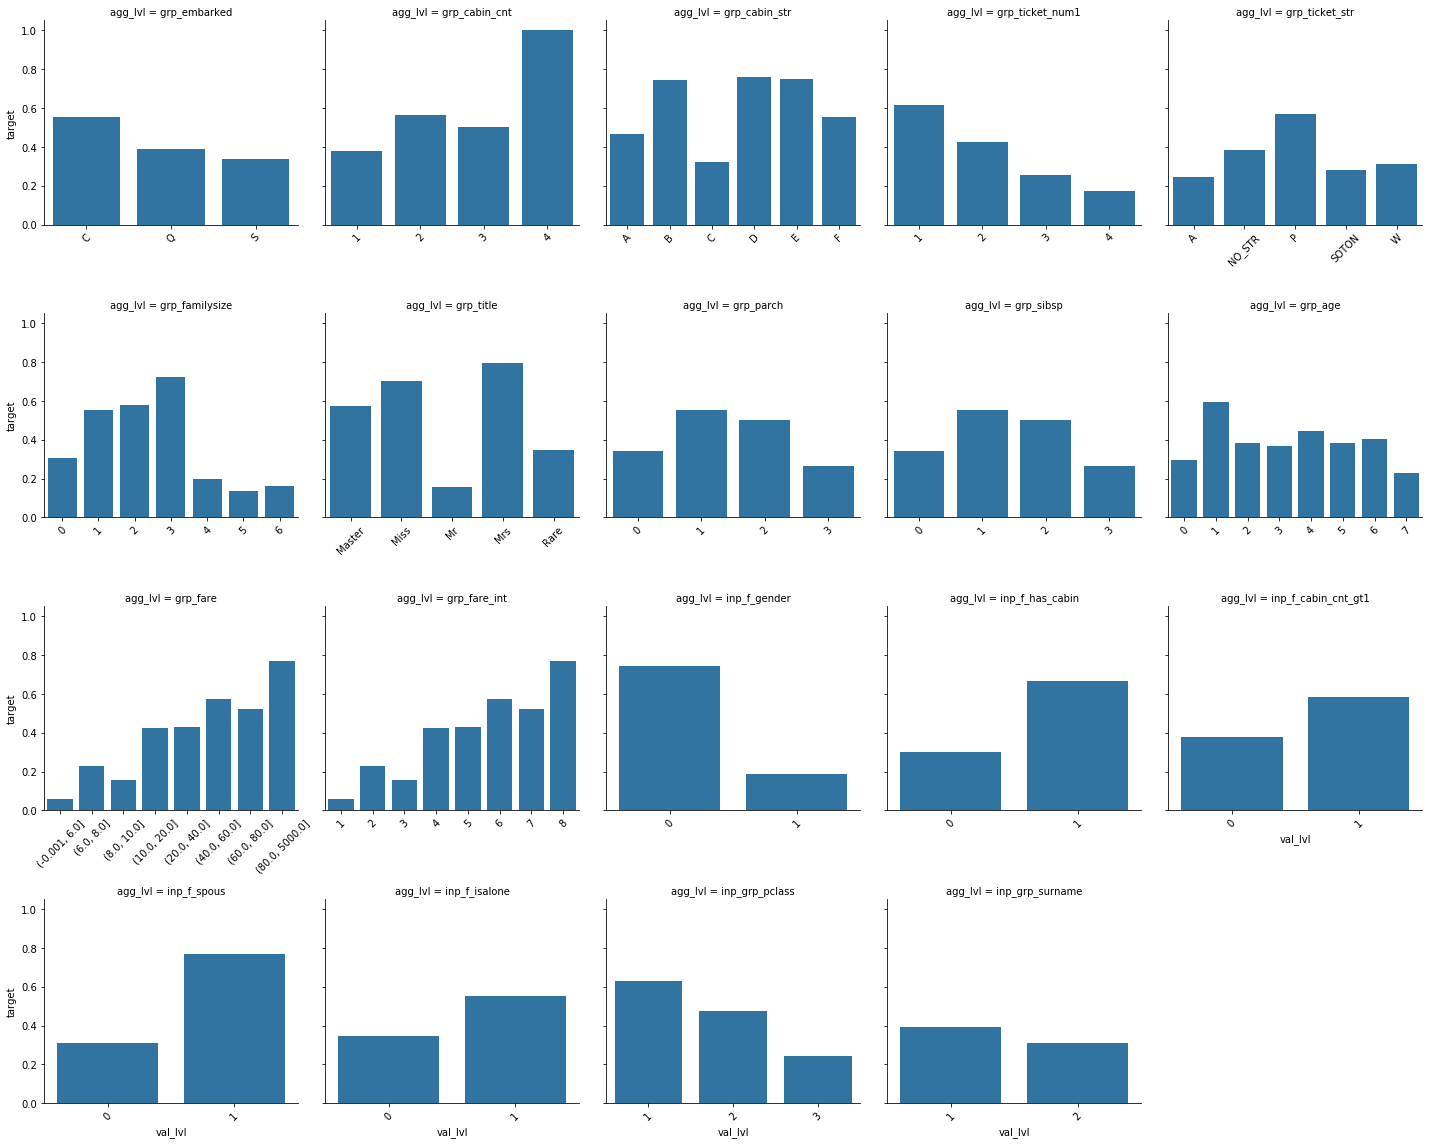

In [2221]:
# Hold modified data
list_hld_grpby=list()

# Work through all discrete columns and calculate mean of target (Basically go from "wide" to "long")
for grp_col in list_col_grp:
    df_agg_tmp=df_train[['target']+[grp_col]].groupby([grp_col],as_index=False).mean()
    df_agg_tmp.rename(columns={grp_col:'val_lvl'}, inplace=True)
    df_agg_tmp['agg_lvl']=grp_col

    # Add to holder
    list_hld_grpby.append(df_agg_tmp)

# Combine to common
df_mlt_agg=pd.concat(list_hld_grpby,sort=True)

# Initialize grid and fill with data
g=sns.FacetGrid(df_mlt_agg, col='agg_lvl', col_wrap=5, sharex=False, height=4)
g.map(sns.barplot, 'val_lvl','target')

# Rotate ticks so high freq discrete x-axis values dont overlap
for ax in g.axes.ravel():
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)

# Tight layout and show()§§
plt.tight_layout()
plt.show()

In [2222]:
def f_distplot_trg(exec_f, indata, list_trg_feat, tpl_figsize):

    """
    This functions creates a distribution plot
    """
    
    if exec_f:
    
        fig, ax=plt.subplots(ncols=1
                            ,nrows=1
                            ,figsize=(tpl_figsize))

        df_tmp=indata[list_trg_feat].sort_values(by=list_trg_feat[0])
        print (df_tmp[list_trg_feat[1]].describe())
        
        for trf_val in (df_tmp[list_trg_feat[0]].drop_duplicates().tolist()):
            sns.distplot(tuple(df_tmp[df_tmp[list_trg_feat[0]]==trf_val][list_trg_feat[1]])) 

        plt.show()
        
    else:
        print ("No execution of function, ending.... ")

count    891.000000
mean      26.965208
std        9.281607
min       12.000000
25%       20.000000
50%       25.000000
75%       30.000000
max       82.000000
Name: inp_len_name, dtype: float64


/nfshome/miniconda3/envs/jnb_credit_risk_py_36/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


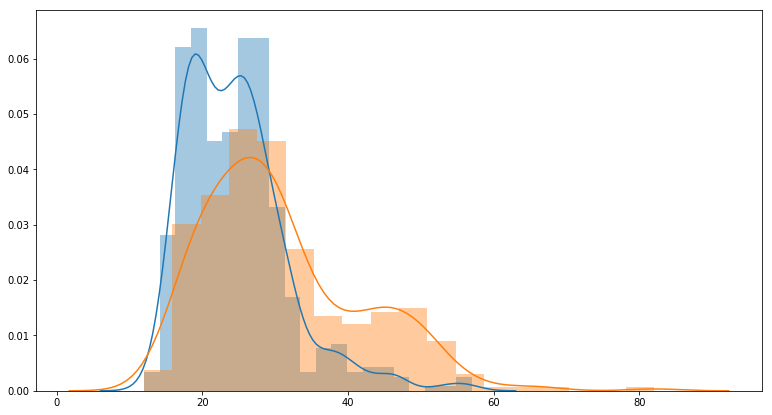

count    891.000000
mean      29.616162
std       13.423053
min        0.000000
25%       22.000000
50%       29.000000
75%       36.000000
max       80.000000
Name: inp_age_imp, dtype: float64


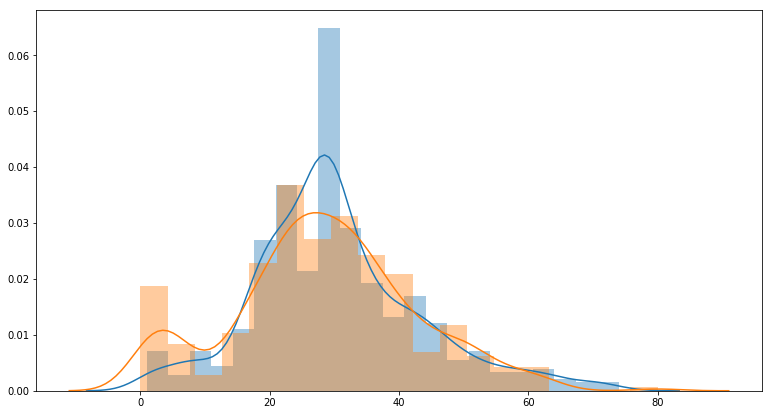

count    891.000000
mean      32.204208
std       49.693429
min        0.000000
25%        7.910400
50%       14.454200
75%       31.000000
max      512.329200
Name: inp_fare, dtype: float64


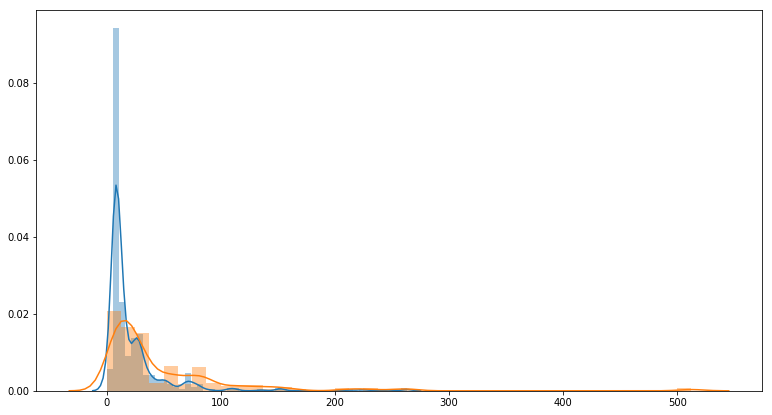

In [2223]:
f_distplot_trg(True, df_train, ['target', 'inp_len_name'], (13,7))
f_distplot_trg(True, df_train, ['target', 'inp_age_imp'], (13,7))
f_distplot_trg(True, df_train, ['target', 'inp_fare'], (13,7))

### Correlation of features

Hopefully the derived features arent to highly correlated, meaning we have redundant information residing in the input data

Features are, excluding dummy coded variables: 
 ['inp_f_gender', 'inp_f_has_cabin', 'inp_f_cabin_cnt_gt1', 'inp_f_spous', 'inp_len_name', 'inp_f_isalone', 'inp_fare', 'inp_age_imp', 'inp_grp_sibsp_woe', 'inp_grp_parch_woe', 'inp_grp_cabin_num_woe', 'inp_grp_cabin_str_int_woe', 'inp_grp_ticket_num1_woe', 'inp_grp_ticket_str_int_woe', 'inp_grp_family_size_woe', 'inp_grp_title_woe', 'inp_grp_surname_woe', 'inp_grp_embarked_woe', 'inp_grp_pclass_woe', 'inp_grp_age_gender2_woe', 'inp_grp_cabin_fare_woe', 'inp_grp_family_size_reduce_woe', 'inp_grp_surname_famsize_woe']


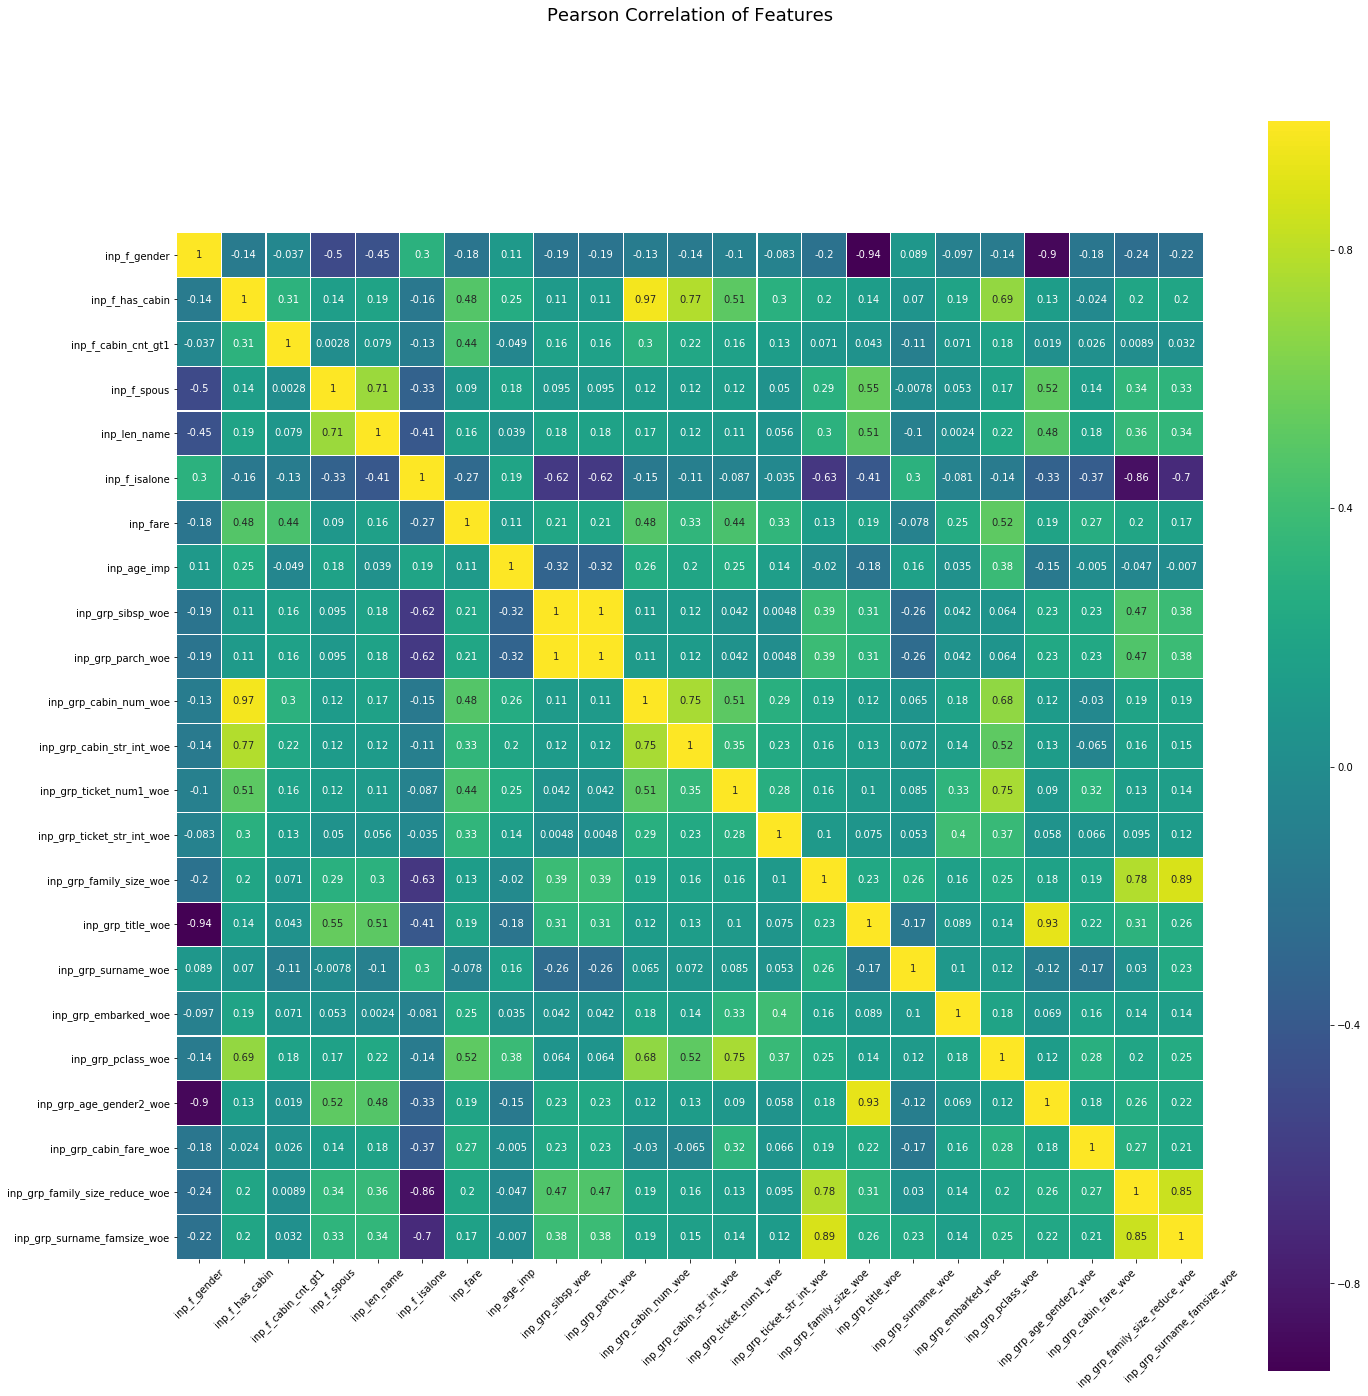

In [1344]:
print ("Features are, excluding dummy coded variables: \n %s" % ([col for col in list_col_inp_feat if col.find('dummy')<0 and col.find('inp_grp')<0] + [col for col in list_col_inp_feat if col.find('woe')>=0]))

colormap=plt.cm.viridis
plt.figure(figsize=(23,23))
plt.title('Pearson Correlation of Features', y=1.2, size=18)

sns.heatmap(df_train[[col for col in list_col_inp_feat if col.find('dummy')<0 and col.find('inp_grp')<0] + [col for col in list_col_inp_feat if col.find('woe')>=0]].astype(float).corr()
            ,linewidths=0.1
            ,vmax=1.0
            ,square=True
            ,cmap=colormap
            ,linecolor='white'
            ,annot=True)

plt.xticks(rotation=45) 

plt.show()

-----
## Algorithms and tests



### Functions

In [423]:
def f_persist_lb_scr(exec_f, clf_algo, indata_test, str_path_out=None, timestamp=None):

    if exec_f:
        
        # What algo are we working with?
        str_algo=str(clf_algo).split('(')[0]
        str_timestamp=str(timestamp).replace('-', '')
    
        # Execute prediction through pipe
        y_test_pred_algo=clf_algo.predict(indata_test)
        
        # Create data - combine prediction with id and set correct metadata
        df_y_test_pred_algo=pd.concat([df_test['id'], pd.DataFrame(y_test_pred_algo)], axis=1)
        df_y_test_pred_algo=df_y_test_pred_algo.rename(columns={'id':'PassengerId', 0:'Survived'})
        df_y_test_pred_algo['PassengerId']=df_y_test_pred_algo['PassengerId'].astype('str')
        df_y_test_pred_algo['Survived']=df_y_test_pred_algo['Survived'].astype('int64')
        
        # Push out to path given parameters
        df_y_test_pred_algo.to_csv(str_path_out+str_algo+"_swepab_"+str_timestamp+".csv", header=True, index=False)
        
        print ("\nPushing algo ouput on test data to path: {} with timestamp: {} and model: {}".format(str_path_out, str_timestamp, str_algo))
        
    else:
        print ("\nNo persist of test data score for public L.B., ending...")
        


In [424]:
def f_get_col_idx(indata, list_cols):
    cols = indata.columns.values
    sidx = np.argsort(cols)
    return sidx[np.searchsorted(cols,list_cols,sorter=sidx)]

In [425]:
class c_FeatureTester(BaseEstimator, TransformerMixin):
    
    def __init__(self
                 ,X_rmv_feat_grp1
                 ,X_rmv_feat_grp2
                 ,X_rmv_feat_grp3

                 ,X_rmv_feat_grp4
                 ,X_rmv_feat_grp5
                 ,X_rmv_feat_grp6

                 ,X_rmv_feat_grp7
                 ,X_rmv_feat_grp8
                 ,X_rmv_feat_grp9
                 ,X_rmv_feat_grp10

                 ,X_rmv_feat_grp11
                 ,X_rmv_feat_grp12
                 
                 
                 ,rmv_feat_grp1=False
                 ,rmv_feat_grp2=False
                 ,rmv_feat_grp3=False

                 ,rmv_feat_grp4=False
                 ,rmv_feat_grp5=False
                 ,rmv_feat_grp6=False

                 ,rmv_feat_grp7=False
                 ,rmv_feat_grp8=False
                 ,rmv_feat_grp9=False
                 ,rmv_feat_grp10=False                 

                 ,rmv_feat_grp11=False                 
                 ,rmv_feat_grp12=False                 
                 
                 
                ):
        
        self.rmv_feat_grp1=rmv_feat_grp1
        self.X_rmv_feat_grp1=X_rmv_feat_grp1
        
        self.rmv_feat_grp2=rmv_feat_grp2
        self.X_rmv_feat_grp2=X_rmv_feat_grp2

        self.rmv_feat_grp3=rmv_feat_grp3
        self.X_rmv_feat_grp3=X_rmv_feat_grp3

        self.rmv_feat_grp4=rmv_feat_grp4
        self.X_rmv_feat_grp4=X_rmv_feat_grp4

        self.rmv_feat_grp5=rmv_feat_grp5
        self.X_rmv_feat_grp5=X_rmv_feat_grp5
        
        self.rmv_feat_grp6=rmv_feat_grp6
        self.X_rmv_feat_grp6=X_rmv_feat_grp6

        self.rmv_feat_grp7=rmv_feat_grp7
        self.X_rmv_feat_grp7=X_rmv_feat_grp7

        self.rmv_feat_grp8=rmv_feat_grp8
        self.X_rmv_feat_grp8=X_rmv_feat_grp8

        self.rmv_feat_grp9=rmv_feat_grp9
        self.X_rmv_feat_grp9=X_rmv_feat_grp9
        
        self.rmv_feat_grp10=rmv_feat_grp10
        self.X_rmv_feat_grp10=X_rmv_feat_grp10    
        
        self.rmv_feat_grp11=rmv_feat_grp11
        self.X_rmv_feat_grp11=X_rmv_feat_grp11
        
        self.rmv_feat_grp12=rmv_feat_grp12
        self.X_rmv_feat_grp12=X_rmv_feat_grp12
                    
    def fit(self, X, y=None):
        return self  # nothing else to do
    
    def transform(self, X, y=None):
        
        # These parameters will be tested in Gridsearch/RandomizedGridSearch given available values (True/False)
        if self.rmv_feat_grp1:            
            list_incl1=[incl for incl in range(0,X.shape[1]) if incl not in (self.X_rmv_feat_grp1)]
            return X[:, list_incl1]            

        elif self.rmv_feat_grp2:            
            list_incl2=[incl for incl in range(0,X.shape[1]) if incl not in (self.X_rmv_feat_grp2)]
            return X[:, list_incl2]     
        
        elif self.rmv_feat_grp3:            
            list_incl3=[incl for incl in range(0,X.shape[1]) if incl not in (self.X_rmv_feat_grp3)]
            return X[:, list_incl3]     

        elif self.rmv_feat_grp4:            
            list_incl4=[incl for incl in range(0,X.shape[1]) if incl not in (self.X_rmv_feat_grp4)]
            return X[:, list_incl4]           

        elif self.rmv_feat_grp5:
            list_incl5=[incl for incl in range(0,X.shape[1]) if incl not in (self.X_rmv_feat_grp5)]
            return X[:, list_incl5]        

        elif self.rmv_feat_grp6:
            list_incl6=[incl for incl in range(0,X.shape[1]) if incl not in (self.X_rmv_feat_grp6)]
            return X[:, list_incl6]        
        
        elif self.rmv_feat_grp7:
            list_incl7=[incl for incl in range(0,X.shape[1]) if incl not in (self.X_rmv_feat_grp7)]
            return X[:, list_incl7]        

        elif self.rmv_feat_grp8:
            list_incl8=[incl for incl in range(0,X.shape[1]) if incl not in (self.X_rmv_feat_grp8)]
            return X[:, list_incl8]        

        elif self.rmv_feat_grp9:
            list_incl9=[incl for incl in range(0,X.shape[1]) if incl not in (self.X_rmv_feat_grp9)]
            return X[:, list_incl9]        

        elif self.rmv_feat_grp10:
            list_incl10=[incl for incl in range(0,X.shape[1]) if incl not in (self.X_rmv_feat_grp10)]
            return X[:, list_incl10]   
        
        
        elif self.rmv_feat_grp11:
            list_incl11=[incl for incl in range(0,X.shape[1]) if incl not in (self.X_rmv_feat_grp11)]
            return X[:, list_incl11]    
        
        elif self.rmv_feat_grp12:
            list_incl12=[incl for incl in range(0,X.shape[1]) if incl not in (self.X_rmv_feat_grp12)]
            return X[:, list_incl12]            
        
        else:
            return X


### Classifiers and parameter grids

In [517]:
#-------------------
# dict_parameter grids
#-------------------
dict_param_lr={'C' : [0.001, 0.01, 0.1, 1, 10]
                }

dict_param_kn={'n_neighbors' : [i for i in range(1, 6)]
                ,'weights' : ['uniform', 'distance']
                }

dict_param_dt={'max_depth' : [i for i in range(1, 10)]
            ,'criterion' : ['gini', 'entropy']
            ,'max_features' : ['auto', 'sqrt', 'log2']
            ,'min_samples_split' : [i*0.1 for i in range(1, 10,2)]
            }

dict_param_rf={'n_estimators' : [i for i in range(1, 500, 20)]
            ,'criterion' : ['gini', 'entropy']
            ,'max_features' : ['auto', 'log2']
            ,'max_depth' : [i for i in range(1, 6,2)]
#             ,'min_samples_split' :  [i*0.1 for i in range(1, 8,2)]
            }

dict_param_et={'n_estimators' : [i for i in range(1, 500, 20)]
            ,'criterion' : ['gini', 'entropy']
            ,'max_features' : ['auto', 'log2']
            ,'max_depth' : [i for i in range(1, 6,2)]
#             ,'min_samples_split' :  [i*0.1 for i in range(1, 8,2)]
            }

dict_param_ab={'n_estimators' : [i for i in range(1, 500, 20)]
                ,'learning_rate' : [0.0001, 0.001, 0.01, 0.1, 1.0]
                }


dict_param_gbm={'n_estimators' :  [i for i in range(1, 500, 20)]
                ,'learning_rate' : [0.0001, 0.001, 0.01, 0.1, 1.0]
                ,'loss' : ['deviance', 'exponential']
                ,'max_features' : ['auto', 'log2']
                ,'max_depth' : [i for i in range(1, 6)]
                ,'min_samples_split' :  [i*0.1 for i in range(1, 8,2)]
#                 ,'subsample' : [i*0.1 for i in range(1, 10)]
                }



#-------------------
# Classifiers
#-------------------
seed=1234

lr=linear_model.LogisticRegression(random_state=seed)
dtre=DecisionTreeClassifier(random_state=seed)
kn=KNeighborsClassifier()
rf=RandomForestClassifier(random_state=seed)
et=ExtraTreesClassifier(random_state=seed)
ab=AdaBoostClassifier(random_state=seed)
gbm=GradientBoostingClassifier(random_state=seed)


list_clf=[lr, kn, dtre, rf, et, ab]

#-------------------------------
# Construct dict_parameter grids
#-------------------------------
list_dict_param_grid=[{'clf__' + k:v for (k, v) in dict_param_lr.items()}
                    ,{'clf__' + k:v for (k, v) in dict_param_kn.items()}
                    ,{'clf__' + k:v for (k, v) in dict_param_dt.items()}
                    ,{'clf__' + k:v for (k, v) in dict_param_rf.items()}
                    ,{'clf__' + k:v for (k, v) in dict_param_et.items()}
                    ,{'clf__' + k:v for (k, v) in dict_param_ab.items()}

                    ]

list_clf_params = list(zip(list_dict_param_grid, list_clf))

--------
## Target vector + Feature matrix

### Execute pipelines and gridsearch

In [2269]:
#----------------------------------------------
# We select target and input flagged features
#----------------------------------------------
np.random.seed(1234)

df_train_final=df_train[['target']+list_col_inp_feat].reset_index(drop=True).astype(float)

df_train_final.fillna(0, inplace=True)

#----------------------
#
#----------------------
y=df_train_final['target']
X=df_train_final[[i for i in df_train_final.columns if i!='target']]

X_test_pub_lb=df_test[list_col_inp_feat]

# X_train=X
# y_train=y
# X_test=X_test_scl

X_trn, X_valid, y_trn, y_valid=train_test_split(X
                                                ,y
                                                ,test_size=0.3
                                                ,random_state=1234
                                                
                                               )


print ("Length X train: %s, length y train: %s" % (len(X), len(y)))
print ("Shape of input featur matrix: %s, shape of target vector: %s \n" % (X.shape, y.shape))
print ("Number of class labels:")
print (pd.Series(y).value_counts().sort_index())

print ("\nTrain shape X, y: {}, {}.".format(X_trn.shape, y_trn.shape))
print ("Valid shape X, y: {}, {}.".format(X_valid.shape, y_valid.shape))


print ("\nLength public test data: {}".format(len(X_test_pub_lb)))

Length X train: 891, length y train: 891
Shape of input featur matrix: (891, 111), shape of target vector: (891,) 

Number of class labels:
0.0    549
1.0    342
Name: target, dtype: int64

Train shape X, y: (623, 111), (623,).
Valid shape X, y: (268, 111), (268,).

Length public test data: 418


### Standard classifiers, shallow GridSearch

In [536]:
print ("{}\n".format(f_dt_now()))
tick=time.time()

# Get index positions from DF on specified columns
X_rmv_feat_grp1=f_get_col_idx(X, ['inp_grp_sibsp','inp_grp_parch']).tolist()
X_rmv_feat_grp2=f_get_col_idx(X, ['inp_grp_age_int','inp_grp_fare_int']).tolist()
X_rmv_feat_grp3=f_get_col_idx(X, ['inp_grp_ticket_num1','inp_grp_ticket_str_int']).tolist()
X_rmv_feat_grp4=f_get_col_idx(X, ['inp_grp_ticket_num1','inp_grp_ticket_str_int']).tolist()
X_rmv_feat_grp5=f_get_col_idx(X, ['inp_grp_ticket_num1','inp_grp_ticket_str_int']).tolist()
X_rmv_feat_grp6=f_get_col_idx(X, ['inp_grp_ticket_num1','inp_grp_ticket_str_int']).tolist()
X_rmv_feat_grp7=f_get_col_idx(X, ['inp_grp_ticket_num1','inp_grp_ticket_str_int']).tolist()
X_rmv_feat_grp8=f_get_col_idx(X, ['inp_grp_ticket_num1','inp_grp_ticket_str_int']).tolist()
X_rmv_feat_grp9=f_get_col_idx(X, ['inp_grp_ticket_num1','inp_grp_ticket_str_int']).tolist()
X_rmv_feat_grp10=f_get_col_idx(X, ['inp_grp_ticket_num1','inp_grp_ticket_str_int']).tolist()
X_rmv_feat_grp11=f_get_col_idx(X, ['inp_grp_ticket_num1','inp_grp_ticket_str_int']).tolist()
X_rmv_feat_grp12=f_get_col_idx(X, ['inp_grp_ticket_num1','inp_grp_ticket_str_int']).tolist()


# Initialize list to hold score for classifier and its accuracy score
list_hld_clf_prf_scr=list()
dict_hld_opt_clf=dict()
dict_hld_clf_param=dict()

#---------------------------------------------------------
# Loop over a set of classifiers and their parameters
#---------------------------------------------------------
for idx_upd, upd_param_grid_dict in enumerate(list_clf_params):

    print ("\n----------------------------------------------------------------------------------------------")
    print ("Classifier being executed is: {}".format(upd_param_grid_dict[1]))
    print ("----------------------------------------------------------------------------------------------")
    
        
    # Generate a pipeline of wanted transformers on data. End with classifier
    pipe=Pipeline([('df_to_mtrx', c_DataFrameToMatrix(None, True))
                  ,('feat_tester', c_FeatureTester(X_rmv_feat_grp1,X_rmv_feat_grp2,X_rmv_feat_grp3,X_rmv_feat_grp4, X_rmv_feat_grp5, X_rmv_feat_grp6, X_rmv_feat_grp7, X_rmv_feat_grp8, X_rmv_feat_grp9, X_rmv_feat_grp10, X_rmv_feat_grp11,X_rmv_feat_grp12))
                  ,('scl', StandardScaler())
                   ,('clf', upd_param_grid_dict[1])]
                   )
    


    print ("Parameters for classifiers is: \n{}".format(upd_param_grid_dict[0]))

    # Parameter grid for classifiers being executed
    param_grid_2={'feat_tester__rmv_feat_grp1' : [False]
                ,'feat_tester__rmv_feat_grp2' : [False]
                ,'feat_tester__rmv_feat_grp3' : [False]
                }

    
        
    # In for loop, we update the dictionary each time with parameters for the given classifier
    param_grid_2.update(upd_param_grid_dict[0])


    # Initialize GridSearch over parameter spacea
    gs_clf=RandomizedSearchCV(estimator=pipe
                            ,param_distributions=param_grid_2
                            ,cv=5
                            ,n_iter=2
                            ,n_jobs=10
                            ,scoring='accuracy'
                            )

    
    
    # Assign names
    X_train=X[[col for col in list_col_inp_feat if col.find('dummy')<0 and col.find('inp_grp')<0]+[woe for woe in list_col_inp_feat if woe.find('woe')>=0]]
    y_train=y    
    
    
    # Fit data
    gs_clf_fit=gs_clf.fit(X_train
                        ,y_train
                        )

    # Best estimator from GridSearch
    gs_optimal_mdl_clf=gs_clf_fit.best_estimator_

    # Predict values, given estimator
    y_train_pred=gs_optimal_mdl_clf.predict(X_train)
    # y_test_pred=gs_optimal_mdl_lg_reg.predict(X_test)

    # Cross validation of optimal GridSearch model
    cv_score= cross_val_score(gs_optimal_mdl_clf
                            ,X_train
                            ,y_train
                            ,scoring='accuracy'
                            ,cv=5
                            ,n_jobs=50)


    print ("Best grid search parameters: %s" % gs_clf.best_params_)
    print ("\n")
    print("Cross validation performance: %0.2f (+/- %0.2f)" % (cv_score.mean(), cv_score.std() * 2))
    print ("\n")

    print ("Classification report:")
    print (classification_report(y_train, y_train_pred))
   
    # Append final score to holder to keep track of everything
    list_hld_clf_prf_scr.append((str(upd_param_grid_dict[1]).split("(")[0]
                                ,"CV score - mean: "+format(cv_score.mean(),"4f")
                                ,"CV score - std: "+format(cv_score.std()*2, "4f")
                                )
                               )
    
    # Hold classifier and optimal parameters
    dict_hld_opt_clf.update({str(upd_param_grid_dict[1]).split("(")[0]:[gs_optimal_mdl_clf, gs_clf.best_params_]})
    
    

list_hld_clf_prf_scr=list_hld_clf_prf_scr
dict_hld_opt_clf=dict_hld_opt_clf
    
print ("\nTotal elapsed time is: {}s".format(round(time.time()-tick,2)))

2019-01-22 19:57:48


----------------------------------------------------------------------------------------------
Classifier being executed is: LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=1234, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
----------------------------------------------------------------------------------------------
Parameters for classifiers is: 
{'clf__C': [0.001, 0.01, 0.1, 1, 10]}
Best grid search parameters: {'feat_tester__rmv_feat_grp3': False, 'feat_tester__rmv_feat_grp2': False, 'feat_tester__rmv_feat_grp1': False, 'clf__C': 0.1}


Cross validation performance: 0.83 (+/- 0.04)


Classification report:
             precision    recall  f1-score   support

        0.0       0.86      0.88      0.87       549
        1.0       0.80      0.77      0.79       342

avg / total       0.84      0.84 

## XGBoost

In [429]:
#----------------------------------------
# Code below for testing feature inputs
#---------------------------------------
def NoRun():
    ml_algo=xgboost.XGBClassifier(random_state=1234,booster='gbtree') 

    param_grid_algo={'clf__n_estimators':[est for est in range(1,1000, 20)]
                    ,'clf__max_depth':[idx for idx in range(2, 8)]
                    ,'clf__min_samples_split':[idx for idx in range(1, 6)]
                    ,'clf__learning_rate':[0.001, 0.01, 0.1, 1.0]
                #             ,'clf__subsample': [0.8,0.9,1.0]
                #             ,'clf__colsample_bytree': [0.8,0.9,1.0]
                    ,'clf__objective':['binary:hinge']
                 }

# Test grid for input features
param_grid_feat_test={'feat_tester__rmv_feat_grp1' : [True,False]
                    ,'feat_tester__rmv_feat_grp2' : [True,False]

                    ,'feat_tester__rmv_feat_grp3' : [True,False]
                    ,'feat_tester__rmv_feat_grp4' : [True,False]

                    ,'feat_tester__rmv_feat_grp5' : [False]
                    ,'feat_tester__rmv_feat_grp6' : [True,False]
                    ,'feat_tester__rmv_feat_grp7' : [True,False]
                    ,'feat_tester__rmv_feat_grp8' : [True,False]

                    ,'feat_tester__rmv_feat_grp9' : [True,False]
                    ,'feat_tester__rmv_feat_grp10': [True,False]

                    ,'feat_tester__rmv_feat_grp11': [True,False]
                    ,'feat_tester__rmv_feat_grp12': [True,False]             
                    }


# Get index positions from DF on specified columns
X_rmv_feat_grp1=f_get_col_idx(df_train_final, ['inp_grp_parch']).tolist()
X_rmv_feat_grp2=f_get_col_idx(df_train_final, ['inp_f_isalone']).tolist()

X_rmv_feat_grp3=f_get_col_idx(df_train_final, ['inp_grp_len_name_int',]).tolist()
X_rmv_feat_grp4=f_get_col_idx(df_train_final, ['inp_f_cabin_cnt_gt1']).tolist()

X_rmv_feat_grp5=f_get_col_idx(df_train_final, ['inp_grp_age_gender']).tolist()
X_rmv_feat_grp6=f_get_col_idx(df_train_final, ['inp_f_spous']).tolist()
X_rmv_feat_grp7=f_get_col_idx(df_train_final, ['inp_grp_sibsp']).tolist()
X_rmv_feat_grp8=f_get_col_idx(df_train_final, ['inp_f_gender']).tolist()

X_rmv_feat_grp9=f_get_col_idx(df_train_final, ['inp_grp_embarked']).tolist()
X_rmv_feat_grp10=f_get_col_idx(df_train_final, ['inp_grp_family_size']).tolist()

X_rmv_feat_grp11=f_get_col_idx(df_train_final, ['inp_grp_cabin_str_int']).tolist()
X_rmv_feat_grp12=f_get_col_idx(df_train_final, ['inp_grp_cabin_str_int']).tolist()

In [2265]:

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 





def f_est_ml_algo(exec_f, ml_algo, param_grid_algo, param_grid_feat_test, list_param_seach, list_param_cv, X_in=None, y_in=None, X_vld=None, y_vld=None, str_desc=None, n_job=-1):
    
    """
    Function wrapper for estimating a scikit learn Machine Learning algorithm for classification or regression tasks.
    
    ml_algo                 Scikit Learn M.L. object
    param_grid_algo         Dictionary: Parameter grid for ml_algo object. Can be fixed paramters, or set of parameters. The grid is always pushed through a grid search.
    param_grid_feat_test    Dictionary or None: Parameter grid for testing input features - 12 slots. Requires that Class c_FeatureTester is assigned
    list_param_search       list (len 3): List with parameters for controling grid search (either exhaustive or randomized). 1: Randomized('rs')/Exhaustive('gs'). 2: Nr of folds. 3: Optimization metric. 4: If 'rs', nr of itteratoins
    list_param_cv           list (len 2): List with parameters for controlling cross-validatoin. 1: nr of folds. 2: optimization metric.
    X_in                    pd.DataFrame/Numpy matrix (n*m): Design matrix used as based for function approximation through specified Machine Learning algorithm, n rows by m input features.
    y_in                    pd.Series/Numpy array (n*1): Target array, i.e. 'ground truth' for function approximation through specified Machine Learning algorithm, n rows by 1.
    y_vld                   pd.DataFrame/Numpy matrix (n*m) or None: Validation data from training set, used as extra hold-out for gauging generalization error
    X_vld                   pd.Series/Numpy array (n*1) or None: Validation data target array from training set, used as extra hold-out for gauging generalization error
    str_desc                String: Description of input for estimation (Data and/or specific parameters). This string + created Timestamp object is used for tracking performance in list list_prf
    n_jobs                  Scalar integer: Number of processes to be used on server
    
    
    """

    if exec_f:
        
        timestamp=f_dt_now()
        print ("{}\n".format(timestamp))
        tick=time.time()


        # Machine Learning algorithm to estimate based on indata and parameters
        algorithm=ml_algo

        # Machine learning parameter grid
        param_grid1=param_grid_algo
        print (param_grid1)
        
        # Parameter grid for testing individual input features
        param_grid2=param_grid_feat_test
        print (param_grid2)

        # We test features, 12 slots available. If none we skip it
        if param_grid2!=None:
            
            print ("\nPipe with feature testing.")
            
            # Generate a pipeline of wanted transformers on data. End with classifier
            pipe=Pipeline([ ('df_to_mtrx', c_DataFrameToMatrix(None, True))
                            ,('scl', StandardScaler())
                            ,('feat_tester', c_FeatureTester(X_rmv_feat_grp1
                                                             ,X_rmv_feat_grp2
                                                             ,X_rmv_feat_grp3
                                                             ,X_rmv_feat_grp4
                                                             ,X_rmv_feat_grp5
                                                             ,X_rmv_feat_grp6
                                                             ,X_rmv_feat_grp7
                                                             ,X_rmv_feat_grp8
                                                             ,X_rmv_feat_grp9
                                                             ,X_rmv_feat_grp10
                                                             ,X_rmv_feat_grp11
                                                             ,X_rmv_feat_grp12
                                                            ))
                            ,('clf', algorithm)])
        

            
            # Update grid as it gets fed into Pipe
            param_grid1.update(param_grid2)


        else:
            
            print ("\nStandard M.L. Pipe")
            # Generate a pipeline of wanted transformers on data. End with classifier
            pipe=Pipeline([ ('df_to_mtrx', c_DataFrameToMatrix(None, True))
                            ,('scl', StandardScaler())
                            ,('clf', algorithm)])
            
  
            


        #---------------------------------------------------------
        # Note:
        # Even if no GS is done and grid is fixed, 
        # the pipe is still pushed through the GridSearch object
        #---------------------------------------------------------

        # Full GridSearch
        if list_param_seach[0]=='gs':
            
            print ("\nExhaustive GridSearch")
            gs_ml_algo = GridSearchCV(pipe
                                  ,param_grid1
                                  ,cv=list_param_seach[1]
                                  ,n_jobs=-1
                                  ,scoring=list_param_seach[2]
                                 )
            
            n_iter=-1

        # Randomized GridSearch
        elif list_param_seach[0]=='rgs':
            
            print ("\nRandomizedGridSearch")
            gs_ml_algo=RandomizedSearchCV(pipe
                                          ,param_grid1
                                          ,cv=list_param_seach[1]
                                          ,n_iter=list_param_seach[3]
                                          ,n_jobs=n_job
                                          ,scoring=list_param_seach[2]
                                         )
            n_iter=list_param_seach[3]

        else:
            print ("No algo or parameters, ending....")



        # Assign names for indata
        X_train=X_in
        y_train=y_in

        
        # Fit data
        gs_clf_fit=gs_ml_algo.fit(X_train
                                ,y_train)

        # Best estimator from GridSearch
        gs_optimal_ml_algo=gs_clf_fit.best_estimator_




        # Predict values, given estimator
        y_train_pred=gs_optimal_ml_algo.predict(X_train)
        
        if X_vld is not None:
            y_vld_pred=gs_optimal_ml_algo.predict(X_vld)

        # Cross validation of optimal GridSearch model
        cv_score= cross_validate(gs_optimal_ml_algo
                                ,X_train
                                ,y_train
                                ,scoring='accuracy'
                                ,cv=5
                                ,n_jobs=n_job)
        

        print ("\nBest grid search parameters: %s" % gs_clf_fit.best_params_)
        print("\nCross validation performance: %0.3f (+/- %0.3f)" % (cv_score['train_score'].mean(), cv_score['train_score'].std()*2))
        print("\nCross validation performance: %0.3f (+/- %0.3f)" % (cv_score['test_score'].mean(), cv_score['test_score'].std()*2))

        
        print ("\nClassification report TRAIN:")
        print (classification_report(y_train, y_train_pred))
        
        if X_vld is not None:
            print ("\nClassification report VALIDATOIN:")
            print (classification_report(y_vld, y_vld_pred))


        print ("\nTotal elapsed time is: {}s".format(round(time.time()-tick,2)))


        # Hold performance
        list_prf=list()

        # List for holding performance
        list_prf.append((str(gs_optimal_ml_algo.get_params()['clf']).split("(")[0]
                        ,timestamp
                        ,"CV score TRAIN - mean: "+format(cv_score['train_score'].mean(),"4f")
                        ,"CV score TEST - mean: "+format(cv_score['test_score'].mean(),"4f")
                        ,"CV score TRAIN - std: "+format(cv_score['train_score'].std()*2, "4f")
                        ,"CV score TEST - std: "+format(cv_score['test_score'].std()*2, "4f")
                        ,n_iter
                        ,str_desc
                            )
                       )
        
        print (gs_clf_fit.best_params_)
        
        # Return result
        return list_prf, gs_optimal_ml_algo, gs_clf_fit.best_params_

    else:
        print ("No execution of estimation, ending....")

In [2266]:
list_hld_prf=list()
n=10000
n_job=40

### Champion

In [594]:
# Parameter grids,  XGB parameters below are hard-coded as Baseline parameters
dict_param_grid_xgb={'clf__learning_rate': [0.01,0.1,1.0]
                ,'clf__max_depth': [idx for idx in range(2, 13,2)]
                ,'clf__min_samples_split': [splt for splt in range(4, 11, 2)]
                ,'clf__n_estimators': [est for est in range(300, 1500, 20)]
                ,'clf__objective': ['binary:logistic']}




# dict_param_grid_xgb={'clf__objective': ['binary:hinge'], 'clf__n_estimators': [120], 'clf__min_samples_split': [6], 'clf__max_depth': [4], 'clf__learning_rate': [0.1]}

param_grid_feat_test=None

clf=xgboost.XGBClassifier(random_state=1234,booster='gbtree') 

#-----------------------------
# Drop zone
#-----------------------------
list_col_rmv=[[col for col in X.columns if col.find(rmv)>=0] for rmv in ['inp_grp_age_gender','inp_grp_title']]
list_col_rmv=[item for rmv in list_col_rmv for item in rmv]

list_col_add=[col for col in list_col_inp_feat if col.find('dummy_title')>=0]

X_col=[col for col in X.columns if col.find('_dummy')<0 and col not in (list_col_rmv) and col.find('woe')<0] + list_col_add


list_prf, ml_clf_itter, dict_clf_param = f_est_ml_algo(True
                                                        ,clf
                                                        ,dict_param_grid_xgb
                                                        ,param_grid_feat_test
                                                        ,['rgs', 5, 'accuracy',n]
                                                        ,[5, 'accuracy']
                                                        ,X_in=X[X_col]
                                                        ,y_in=y
                                                        ,str_desc='"Champion", mix Ordinal and Dummy. No WoE'
                                                        ,n_job=n_job)

list_hld_prf.append((list_prf
                     ,ml_clf_itter
                     ,dict_clf_param
                     ,ml_clf_itter.predict(X_test_pub_lb[X_col]))
                     )

2019-01-23 05:18:09

{'clf__learning_rate': [0.01, 0.1, 1.0], 'clf__max_depth': [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12], 'clf__min_samples_split': [4, 5, 6, 7, 8, 9, 10], 'clf__n_estimators': [300, 320, 340, 360, 380, 400, 420, 440, 460, 480, 500, 520, 540, 560, 580, 600, 620, 640, 660, 680, 700, 720, 740, 760, 780, 800, 820, 840, 860, 880, 900, 920, 940, 960, 980, 1000, 1020, 1040, 1060, 1080, 1100, 1120, 1140, 1160, 1180, 1200, 1220, 1240, 1260, 1280, 1300, 1320, 1340, 1360, 1380, 1400, 1420, 1440, 1460, 1480], 'clf__objective': ['binary:hinge', 'binary:logistic']}
None

Standard M.L. Pipe

RandomizedGridSearch

Best grid search parameters: {'clf__objective': 'binary:logistic', 'clf__n_estimators': 1420, 'clf__min_samples_split': 4, 'clf__max_depth': 4, 'clf__learning_rate': 0.01}

Cross validation performance: 0.83 (+/- 0.03)

Classification report TRAIN:
             precision    recall  f1-score   support

        0.0       0.93      0.97      0.95       549
        1.0       0.95   

,importance,feature
14,0.249864,inp_fare
15,0.247831,inp_age_imp
11,0.201125,inp_len_name
7,0.052671,inp_grp_ticket_num1
9,0.041825,inp_grp_family_size
6,0.037961,inp_grp_cabin_str_int
5,0.032877,inp_grp_cabin_num
2,0.027657,inp_f_gender
13,0.025488,inp_grp_embarked
8,0.024132,inp_grp_ticket_str_int


{'clf__objective': 'binary:logistic', 'clf__n_estimators': 1420, 'clf__min_samples_split': 4, 'clf__max_depth': 4, 'clf__learning_rate': 0.01}


### All discrete

#### Exhausive GS to find parameters

In [1716]:
# Parameter grids,  XGB parameters below are hard-coded as Baseline parameters
# dict_param_grid_xgb={'clf__objective': ['binary:hinge'], 'clf__n_estimators': [120], 'clf__min_samples_split': [6], 'clf__max_depth': [4], 'clf__learning_rate': [0.1]}

dict_param_grid_xgb={'clf__learning_rate': [0.01,0.1,1.0]
                ,'clf__max_depth': [idx for idx in range(2, 13,2)]
                ,'clf__min_samples_split': [splt for splt in range(4, 11, 2)]
                ,'clf__n_estimators': [est for est in range(300, 2000, 20)]
                ,'clf__objective': ['binary:logistic']}


#-----------------------------
# Drop zone
#-----------------------------
list_col_rmv=[[col for col in X.columns if col.find(rmv)>=0] for rmv in ['inp_grp_age_gender'] + [dmmy2 for dmmy2 in list_col_inp_feat if dmmy2.find("2_")>=0]]
list_col_rmv=[item for rmv in list_col_rmv for item in rmv]

X_col=[col for col in list_col_inp_feat if col.find('dummy')<0 and col[-3:]!='woe']

list_prf, ml_clf_itter, dict_clf_param  = f_est_ml_algo(True
                                              ,xgboost.XGBClassifier(random_state=1234,booster='gbtree') 
                                              ,dict_param_grid_xgb
                                              ,param_grid_feat_test
                                              ,['gs', 5, 'accuracy']
                                              ,[5, 'accuracy']
                                              ,X_in=X[X_col]
                                              ,y_in=y
                                              ,str_desc='All discrete Ordinal'
                                             ,n_job=n_job)

list_hld_prf.append((list_prf
                     ,ml_clf_itter
                     ,dict_clf_param
                     ,ml_clf_itter.predict(X_test_pub_lb[X_col])
                     ))

2019-01-30 11:10:50

{'clf__learning_rate': [0.01, 0.1, 1.0], 'clf__max_depth': [2, 4, 6, 8, 10, 12], 'clf__min_samples_split': [4, 6, 8, 10], 'clf__n_estimators': [300, 320, 340, 360, 380, 400, 420, 440, 460, 480, 500, 520, 540, 560, 580, 600, 620, 640, 660, 680, 700, 720, 740, 760, 780, 800, 820, 840, 860, 880, 900, 920, 940, 960, 980, 1000, 1020, 1040, 1060, 1080, 1100, 1120, 1140, 1160, 1180, 1200, 1220, 1240, 1260, 1280, 1300, 1320, 1340, 1360, 1380, 1400, 1420, 1440, 1460, 1480, 1500, 1520, 1540, 1560, 1580, 1600, 1620, 1640, 1660, 1680, 1700, 1720, 1740, 1760, 1780, 1800, 1820, 1840, 1860, 1880, 1900, 1920, 1940, 1960, 1980], 'clf__objective': ['binary:logistic']}
None

Standard M.L. Pipe

Exhaustive GridSearch

Best grid search parameters: {'clf__learning_rate': 0.01, 'clf__max_depth': 4, 'clf__min_samples_split': 4, 'clf__n_estimators': 1720, 'clf__objective': 'binary:logistic'}

Cross validation performance: 0.838 (+/- 0.038)

Classification report TRAIN:
             precisi

,importance,feature
14,0.265767,inp_fare
16,0.237863,inp_age_imp
11,0.183303,inp_len_name
20,0.051724,inp_grp_pclass_gender
4,0.036411,inp_grp_cabin_num
8,0.034256,inp_grp_family_size
7,0.033235,inp_grp_ticket_str_int
6,0.028358,inp_grp_ticket_num1
5,0.023877,inp_grp_cabin_str_int
13,0.022799,inp_grp_embarked


{'clf__learning_rate': 0.01, 'clf__max_depth': 4, 'clf__min_samples_split': 4, 'clf__n_estimators': 1720, 'clf__objective': 'binary:logistic'}


#### GS to find optimal nr of input

In [2250]:
list_col_drop=['inp_grp_isalone_gender'
                ,'inp_grp_surname_famsize'
                ,'inp_grp_cabin_fare'
                ,'inp_grp_surname'
                ,'inp_f_spous'
                ,'inp_grp_sibsp'
                ,'inp_f_gender'
                ,'inp_f_has_cabin'
                ,'inp_grp_age_gender2'
                ,'inp_grp_pclass'
                ,'inp_grp_parch'
              ,'inp_len_name']

In [2270]:
# Parameter grids,  XGB parameters below are hard-coded as Baseline parameters
dict_param_grid_xgb={'clf__learning_rate': [0.01], 'clf__max_depth': [4], 'clf__min_samples_split': [4], 'clf__n_estimators': [1720], 'clf__objective': ['binary:logistic']}

# dict_param_grid_xgb={'clf__learning_rate': [0.01,0.1,1.0]
#                 ,'clf__max_depth': [idx for idx in range(2, 13,2)]
#                 ,'clf__min_samples_split': [splt for splt in range(4, 11, 2)]
#                 ,'clf__n_estimators': [est for est in range(300, 2000, 20)]
#                 ,'clf__objective': ['binary:logistic']}

# Test grid for input features
# param_grid_feat_test={'feat_tester__rmv_feat_grp1' :[False]
#                     ,'feat_tester__rmv_feat_grp2' : [False]
#                     ,'feat_tester__rmv_feat_grp3' : [False]
#                     ,'feat_tester__rmv_feat_grp4' : [False]
#                     ,'feat_tester__rmv_feat_grp5' : [False]
#                     ,'feat_tester__rmv_feat_grp6' : [False]
#                     ,'feat_tester__rmv_feat_grp7' : [False]
#                     ,'feat_tester__rmv_feat_grp8' : [False]
#                     ,'feat_tester__rmv_feat_grp9' : [False]
#                     ,'feat_tester__rmv_feat_grp10': [False]
#                     ,'feat_tester__rmv_feat_grp11': [False]
#                     ,'feat_tester__rmv_feat_grp12': [False]             
#                     }

param_grid_feat_test=None


# Get index positions from DF on specified columns
# X_rmv_feat_grp1=f_get_col_idx(df_train_final, ['inp_grp_parch']).tolist()
# X_rmv_feat_grp2=f_get_col_idx(df_train_final, ['inp_grp_pclass']).tolist()
# X_rmv_feat_grp3=f_get_col_idx(df_train_final, ['inp_grp_age_gender2',]).tolist()
# X_rmv_feat_grp4=f_get_col_idx(df_train_final, ['inp_f_has_cabin']).tolist()
# X_rmv_feat_grp5=f_get_col_idx(df_train_final, ['inp_f_gender']).tolist()
# X_rmv_feat_grp6=f_get_col_idx(df_train_final, ['inp_grp_sibsp']).tolist()
# X_rmv_feat_grp7=f_get_col_idx(df_train_final, ['inp_f_spous']).tolist()
# X_rmv_feat_grp8=f_get_col_idx(df_train_final, ['inp_grp_surname']).tolist()
# X_rmv_feat_grp9=f_get_col_idx(df_train_final, ['inp_grp_cabin_fare']).tolist()
# X_rmv_feat_grp10=f_get_col_idx(df_train_final, ['inp_grp_surname_famsize']).tolist()
# X_rmv_feat_grp11=f_get_col_idx(df_train_final, ['inp_grp_isalone_gender']).tolist()
# X_rmv_feat_grp12=f_get_col_idx(df_train_final, ['inp_grp_title']).tolist()

#-----------------------------
# Drop zone
#-----------------------------
X_col=[col for col in list_col_inp_feat if col.find('dummy')<0 and col[-3:]!='woe' and col not in (list_col_drop)]

list_prf, ml_clf_itter, dict_clf_param  = f_est_ml_algo(True
                                              ,xgboost.XGBClassifier(random_state=1234,booster='gbtree') 
                                              ,dict_param_grid_xgb
                                              ,param_grid_feat_test
                                              ,['gs', 5, 'accuracy']
                                              ,[5, 'accuracy']
                                              ,X_in=X_trn[X_col]
                                              ,y_in=y_trn
                                              ,X_vld=X_valid[X_col]
                                              ,y_vld=y_valid
                                             ,str_desc='All discrete Ordinal - WITH VALIDATION'
                                             ,n_job=n_job)

list_hld_prf.append((list_prf
                     ,ml_clf_itter
                     ,dict_clf_param
                     ,ml_clf_itter.predict(X_test_pub_lb[X_col])
                     ))

2019-02-19 12:45:27

{'clf__learning_rate': [0.01], 'clf__max_depth': [4], 'clf__min_samples_split': [4], 'clf__n_estimators': [1720], 'clf__objective': ['binary:logistic']}
None

Standard M.L. Pipe

Exhaustive GridSearch

Best grid search parameters: {'clf__learning_rate': 0.01, 'clf__max_depth': 4, 'clf__min_samples_split': 4, 'clf__n_estimators': 1720, 'clf__objective': 'binary:logistic'}

Cross validation performance: 0.941 (+/- 0.020)

Cross validation performance: 0.815 (+/- 0.057)

Classification report TRAIN:
             precision    recall  f1-score   support

        0.0       0.92      0.96      0.94       383
        1.0       0.94      0.87      0.90       240

avg / total       0.93      0.93      0.93       623


Classification report VALIDATOIN:
             precision    recall  f1-score   support

        0.0       0.86      0.93      0.89       166
        1.0       0.86      0.75      0.80       102

avg / total       0.86      0.86      0.86       268


Total elaps

/nfshome/miniconda3/envs/jnb_credit_risk_py_36/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/nfshome/miniconda3/envs/jnb_credit_risk_py_36/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)


In [2271]:
# Parameter grids,  XGB parameters below are hard-coded as Baseline parameters
dict_param_grid_xgb={'clf__learning_rate': [0.01], 'clf__max_depth': [4], 'clf__min_samples_split': [4], 'clf__n_estimators': [1720], 'clf__objective': ['binary:logistic']}

# dict_param_grid_xgb={'clf__learning_rate': [0.01,0.1,1.0]
#                 ,'clf__max_depth': [idx for idx in range(2, 13,2)]
#                 ,'clf__min_samples_split': [splt for splt in range(4, 11, 2)]
#                 ,'clf__n_estimators': [est for est in range(300, 2000, 20)]
#                 ,'clf__objective': ['binary:logistic']}

# Test grid for input features
# param_grid_feat_test={'feat_tester__rmv_feat_grp1' :[False]
#                     ,'feat_tester__rmv_feat_grp2' : [False]
#                     ,'feat_tester__rmv_feat_grp3' : [False]
#                     ,'feat_tester__rmv_feat_grp4' : [False]
#                     ,'feat_tester__rmv_feat_grp5' : [False]
#                     ,'feat_tester__rmv_feat_grp6' : [False]
#                     ,'feat_tester__rmv_feat_grp7' : [False]
#                     ,'feat_tester__rmv_feat_grp8' : [False]
#                     ,'feat_tester__rmv_feat_grp9' : [False]
#                     ,'feat_tester__rmv_feat_grp10': [False]
#                     ,'feat_tester__rmv_feat_grp11': [False]
#                     ,'feat_tester__rmv_feat_grp12': [False]             
#                     }

param_grid_feat_test=None


# Get index positions from DF on specified columns
# X_rmv_feat_grp1=f_get_col_idx(df_train_final, ['inp_grp_parch']).tolist()
# X_rmv_feat_grp2=f_get_col_idx(df_train_final, ['inp_grp_pclass']).tolist()
# X_rmv_feat_grp3=f_get_col_idx(df_train_final, ['inp_grp_age_gender2',]).tolist()
# X_rmv_feat_grp4=f_get_col_idx(df_train_final, ['inp_f_has_cabin']).tolist()
# X_rmv_feat_grp5=f_get_col_idx(df_train_final, ['inp_f_gender']).tolist()
# X_rmv_feat_grp6=f_get_col_idx(df_train_final, ['inp_grp_sibsp']).tolist()
# X_rmv_feat_grp7=f_get_col_idx(df_train_final, ['inp_f_spous']).tolist()
# X_rmv_feat_grp8=f_get_col_idx(df_train_final, ['inp_grp_surname']).tolist()
# X_rmv_feat_grp9=f_get_col_idx(df_train_final, ['inp_grp_cabin_fare']).tolist()
# X_rmv_feat_grp10=f_get_col_idx(df_train_final, ['inp_grp_surname_famsize']).tolist()
# X_rmv_feat_grp11=f_get_col_idx(df_train_final, ['inp_grp_isalone_gender']).tolist()
# X_rmv_feat_grp12=f_get_col_idx(df_train_final, ['inp_grp_title']).tolist()

#-----------------------------
# Drop zone
#-----------------------------
X_col=[col for col in list_col_inp_feat if col.find('dummy')<0 and col[-3:]!='woe' and col not in (list_col_drop+['inp_fare', 'inp_age_imp'])]+['inp_grp_fare_int']

list_prf, ml_clf_itter, dict_clf_param  = f_est_ml_algo(True
                                              ,xgboost.XGBClassifier(random_state=1234,booster='gbtree') 
                                              ,dict_param_grid_xgb
                                              ,param_grid_feat_test
                                              ,['gs', 5, 'accuracy']
                                              ,[5, 'accuracy']
                                              ,X_in=X_trn[X_col]
                                              ,y_in=y_trn
                                              ,X_vld=X_valid[X_col]
                                              ,y_vld=y_valid
                                              ,str_desc='All discrete Ordinal, with added grp_age_in and grp_fare_int. Drop list applied - WITH VALIDATION'
                                             ,n_job=n_job)

list_hld_prf.append((list_prf
                     ,ml_clf_itter
                     ,dict_clf_param
                     ,ml_clf_itter.predict(X_test_pub_lb[X_col])
                     ))

2019-02-19 12:46:16

{'clf__learning_rate': [0.01], 'clf__max_depth': [4], 'clf__min_samples_split': [4], 'clf__n_estimators': [1720], 'clf__objective': ['binary:logistic']}
None

Standard M.L. Pipe

Exhaustive GridSearch

Best grid search parameters: {'clf__learning_rate': 0.01, 'clf__max_depth': 4, 'clf__min_samples_split': 4, 'clf__n_estimators': 1720, 'clf__objective': 'binary:logistic'}

Cross validation performance: 0.915 (+/- 0.019)

Cross validation performance: 0.812 (+/- 0.046)

Classification report TRAIN:
             precision    recall  f1-score   support

        0.0       0.90      0.95      0.92       383
        1.0       0.91      0.82      0.87       240

avg / total       0.90      0.90      0.90       623


Classification report VALIDATOIN:
             precision    recall  f1-score   support

        0.0       0.86      0.89      0.88       166
        1.0       0.81      0.77      0.79       102

avg / total       0.84      0.84      0.84       268


Total elaps

/nfshome/miniconda3/envs/jnb_credit_risk_py_36/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/nfshome/miniconda3/envs/jnb_credit_risk_py_36/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)


In [2132]:
df_clf_prf=pd.concat([pd.DataFrame(df_prf[0]).rename(columns={0:'Model', 1:'Timestamp', 2:'CV_Mean', 3:'CV_Std', 4:'Nr_Itterations', 5:'Comment'}) for df_prf in list_hld_prf]).reset_index(drop=True)
df_clf_prf

,Model,Timestamp,CV_Mean,CV_Std,Nr_Itterations,Comment
0,XGBClassifier,2019-01-30 11:10:50,CV score - mean: 0.838414,CV score - std: 0.038494,-1,All discrete Ordinal
1,XGBClassifier,2019-01-30 11:32:19,CV score - mean: 0.841759,CV score - std: 0.038246,-1,WoE estimation for Ordinal features
2,XGBClassifier,2019-01-30 11:54:40,CV score - mean: 0.841759,CV score - std: 0.038246,-1,WoE estimation for Ordinal features
3,XGBClassifier,2019-01-30 11:54:57,CV score - mean: 0.838414,CV score - std: 0.038494,-1,All discrete Ordinal
4,XGBClassifier,2019-01-30 12:43:33,CV score - mean: 0.838414,CV score - std: 0.038494,-1,All discrete Ordinal
5,XGBClassifier,2019-01-30 12:59:56,CV score - mean: 0.841759,CV score - std: 0.038246,-1,WoE estimation for Ordinal features
6,XGBClassifier,2019-01-30 14:29:04,CV score - mean: 0.827184,CV score - std: 0.035963,-1,All discrete Ordinal
7,XGBClassifier,2019-01-30 14:31:53,CV score - mean: 0.833907,CV score - std: 0.043296,-1,test
8,XGBClassifier,2019-01-30 14:32:48,CV score - mean: 0.827171,CV score - std: 0.030944,-1,test
9,XGBClassifier,2019-01-30 14:34:08,CV score - mean: 0.827171,CV score - std: 0.030944,-1,test


In [1922]:
f_persist_lb_scr(True
                ,[algo[1] for algo in list_hld_prf][13]
                 ,X_test_pub_lb[X_col]
                 ,str_path_out='/nfshome/patblo/code/Other/Boat/'
                 ,timestamp=f_d_now())


Pushing algo ouput on test data to path: /nfshome/patblo/code/Other/Boat/ with timestamp: 20190130 and model: Pipeline


In [1753]:
def f_get_dummy(str_col_name):
    return [dmmy for dmmy in [dummy for dummy in list_col_inp_feat if dummy.find('dummy')>=0] if dmmy.find(str_col_name)>=0 

['inp_dummy_surn_famsize_11',
 'inp_dummy_surn_famsize_12',
 'inp_dummy_surn_famsize_13',
 'inp_dummy_surn_famsize_21',
 'inp_dummy_surn_famsize_22',
 'inp_dummy_surn_famsize_23']

### All WoE

#### GS to find optimal model parameters

In [2272]:
# Parameter grids,  XGB parameters below are hard-coded as Baseline parameters
# dict_param_grid_xgb={'clf__objective': ['binary:hinge'], 'clf__n_estimators': [120], 'clf__min_samples_split': [6], 'clf__max_depth': [4], 'clf__learning_rate': [0.1]}

dict_param_grid_xgb={'clf__learning_rate': [0.01,0.1,1.0]
                ,'clf__max_depth': [idx for idx in range(2, 13,2)]
                ,'clf__min_samples_split': [splt for splt in range(4, 11, 2)]
                ,'clf__n_estimators': [est for est in range(300, 1500, 20)]
                ,'clf__objective': ['binary:logistic']}

#-----------------------------
# Drop zone
#-----------------------------
X_col=[col for col in list_col_inp_feat if col.find('dummy')<0 and col[0:7]!='inp_grp']+[col for col in list_col_inp_feat if col.find('woe')>=0]

list_prf, ml_clf_itter,dict_clf_param = f_est_ml_algo(True
                                                    ,xgboost.XGBClassifier(random_state=1234,booster='gbtree') 
                                                    ,dict_param_grid_xgb
                                                    ,param_grid_feat_test
                                                   ,['gs', 5, 'accuracy']
                                                    ,[5, 'accuracy']
                                                      ,X_in=X_trn[X_col]
                                                      ,y_in=y_trn
                                                      ,X_vld=X_valid[X_col]
                                                      ,y_vld=y_valid
                                                    ,str_desc='WoE estimation for Ordinal features - WITH VALIDATION'
                                                    ,n_job=n_job)

list_hld_prf.append((list_prf
                     ,ml_clf_itter
                     ,dict_clf_param
                     ,ml_clf_itter.predict(X_test_pub_lb[X_col])
                     ))

2019-02-19 12:46:35

{'clf__learning_rate': [0.01, 0.1, 1.0], 'clf__max_depth': [2, 4, 6, 8, 10, 12], 'clf__min_samples_split': [4, 6, 8, 10], 'clf__n_estimators': [300, 320, 340, 360, 380, 400, 420, 440, 460, 480, 500, 520, 540, 560, 580, 600, 620, 640, 660, 680, 700, 720, 740, 760, 780, 800, 820, 840, 860, 880, 900, 920, 940, 960, 980, 1000, 1020, 1040, 1060, 1080, 1100, 1120, 1140, 1160, 1180, 1200, 1220, 1240, 1260, 1280, 1300, 1320, 1340, 1360, 1380, 1400, 1420, 1440, 1460, 1480], 'clf__objective': ['binary:logistic']}
None

Standard M.L. Pipe

Exhaustive GridSearch

Best grid search parameters: {'clf__learning_rate': 0.01, 'clf__max_depth': 4, 'clf__min_samples_split': 4, 'clf__n_estimators': 360, 'clf__objective': 'binary:logistic'}

Cross validation performance: 0.896 (+/- 0.018)

Cross validation performance: 0.847 (+/- 0.058)

Classification report TRAIN:
             precision    recall  f1-score   support

        0.0       0.88      0.96      0.91       383
        1.0    

/nfshome/miniconda3/envs/jnb_credit_risk_py_36/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/nfshome/miniconda3/envs/jnb_credit_risk_py_36/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)


#### GS to find optimal nr of inputs

In [2273]:
# Parameter grids,  XGB parameters below are hard-coded as Baseline parameters
dict_param_grid_xgb= {'clf__learning_rate': [0.01], 'clf__max_depth': [4], 'clf__min_samples_split': [4], 'clf__n_estimators': [1340], 'clf__objective': ['binary:logistic']}

# dict_param_grid_xgb={'clf__learning_rate': [0.01,0.1,1.0]
#                 ,'clf__max_depth': [idx for idx in range(2, 13,2)]
#                 ,'clf__min_samples_split': [splt for splt in range(4, 11, 2)]
#                 ,'clf__n_estimators': [est for est in range(300, 1500, 20)]
#                 ,'clf__objective': ['binary:logistic']}

# Test grid for input features
# Test grid for input features
param_grid_feat_test={'feat_tester__rmv_feat_grp1' :[True,False]
                    ,'feat_tester__rmv_feat_grp2' : [True,False]
                    ,'feat_tester__rmv_feat_grp3' : [True,False]
                    ,'feat_tester__rmv_feat_grp4' : [True,False]
                    ,'feat_tester__rmv_feat_grp5' : [True,False]
                    ,'feat_tester__rmv_feat_grp6' : [True,False]
                    ,'feat_tester__rmv_feat_grp7' : [True,False]
                    ,'feat_tester__rmv_feat_grp8' : [True,False]
                    ,'feat_tester__rmv_feat_grp9' : [True,False]
                    ,'feat_tester__rmv_feat_grp10': [True,False]
                    ,'feat_tester__rmv_feat_grp11': [True,False]
                    ,'feat_tester__rmv_feat_grp12': [True,False]             
                    }


# Get index positions from DF on specified columns
X_rmv_feat_grp1=f_get_col_idx(df_train_final, ['inp_grp_parch_woe']).tolist()
X_rmv_feat_grp2=f_get_col_idx(df_train_final, ['inp_grp_age_gender2_woe']).tolist()
X_rmv_feat_grp3=f_get_col_idx(df_train_final, ['inp_grp_surname_woe',]).tolist()
X_rmv_feat_grp4=f_get_col_idx(df_train_final, ['inp_f_gender']).tolist()
X_rmv_feat_grp5=f_get_col_idx(df_train_final, ['inp_f_has_cabin']).tolist()
X_rmv_feat_grp6=f_get_col_idx(df_train_final, ['inp_grp_pclass_woe']).tolist()
X_rmv_feat_grp7=f_get_col_idx(df_train_final, ['inp_grp_sibsp_woe']).tolist()
X_rmv_feat_grp8=f_get_col_idx(df_train_final, ['inp_grp_isalone_gender_woe']).tolist()
X_rmv_feat_grp9=f_get_col_idx(df_train_final, ['inp_f_spous']).tolist()
X_rmv_feat_grp10=f_get_col_idx(df_train_final, ['inp_grp_cabin_fare_woe']).tolist()
X_rmv_feat_grp11=f_get_col_idx(df_train_final, ['inp_grp_surname_famsize_woe']).tolist()
X_rmv_feat_grp12=f_get_col_idx(df_train_final, ['inp_grp_cabin_str_int_woe']).tolist()


#-----------------------------
# Drop zone
#-----------------------------
X_col=[col for col in list_col_inp_feat if col.find('dummy')<0 and col[0:7]!='inp_grp']+[col for col in list_col_inp_feat if col.find('woe')>=0]

list_prf, ml_clf_itter,dict_clf_param = f_est_ml_algo(True
                                                    ,xgboost.XGBClassifier(random_state=1234,booster='gbtree') 
                                                    ,dict_param_grid_xgb
                                                    ,param_grid_feat_test
                                                   ,['gs', 5, 'accuracy']
                                                    ,[5, 'accuracy']
                                                      ,X_in=X_trn[X_col]
                                                      ,y_in=y_trn
                                                      ,X_vld=X_valid[X_col]
                                                      ,y_vld=y_valid
                                                    ,str_desc='WoE estimation for Ordinal features - WITH VALIDATION'
                                                    ,n_job=n_job)

list_hld_prf.append((list_prf
                     ,ml_clf_itter
                     ,dict_clf_param
                     ,ml_clf_itter.predict(X_test_pub_lb[X_col])
                     ))

2019-02-19 12:55:36

{'clf__learning_rate': [0.01], 'clf__max_depth': [4], 'clf__min_samples_split': [4], 'clf__n_estimators': [1340], 'clf__objective': ['binary:logistic']}
{'feat_tester__rmv_feat_grp1': [True, False], 'feat_tester__rmv_feat_grp2': [True, False], 'feat_tester__rmv_feat_grp3': [True, False], 'feat_tester__rmv_feat_grp4': [True, False], 'feat_tester__rmv_feat_grp5': [True, False], 'feat_tester__rmv_feat_grp6': [True, False], 'feat_tester__rmv_feat_grp7': [True, False], 'feat_tester__rmv_feat_grp8': [True, False], 'feat_tester__rmv_feat_grp9': [True, False], 'feat_tester__rmv_feat_grp10': [True, False], 'feat_tester__rmv_feat_grp11': [True, False], 'feat_tester__rmv_feat_grp12': [True, False]}

Pipe with feature testing.

Exhaustive GridSearch

Best grid search parameters: {'clf__learning_rate': 0.01, 'clf__max_depth': 4, 'clf__min_samples_split': 4, 'clf__n_estimators': 1340, 'clf__objective': 'binary:logistic', 'feat_tester__rmv_feat_grp1': True, 'feat_tester__rmv_feat

/nfshome/miniconda3/envs/jnb_credit_risk_py_36/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/nfshome/miniconda3/envs/jnb_credit_risk_py_36/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)


In [1736]:
f_persist_lb_scr(True
                ,[algo[1] for algo in list_hld_prf][5]
                 ,X_test_pub_lb[X_col]
                 ,str_path_out='/nfshome/patblo/code/Other/Boat/'
                 ,timestamp=f_d_now())


Pushing algo ouput on test data to path: /nfshome/patblo/code/Other/Boat/ with timestamp: 20190130 and model: Pipeline


In [1693]:
def NoRun():

    #-----------------------------------------
    # Prepp columns and data
    # for gender segmented model
    #-----------------------------------------
    list_col_drop_gender=[gender for gender in list_col_inp_feat if gender.find('inp_f_gender')>=0]

    # Male
    X_m=X[X['inp_f_gender']==1]
    X_m.drop(list_col_drop_gender, axis=1, inplace=True)
    y_m=y[y.index.isin(X_m.index)]

    # Female
    X_f=X[X['inp_f_gender']==0]
    X_f.drop(list_col_drop_gender, inplace=True, axis=1)
    y_f=y[y.index.isin(X_f.index)]

    # Test: Male and Female
    X_test_pub_lb_m=X_test_pub_lb[X_test_pub_lb['inp_f_gender']==1]
    X_test_pub_lb_m.drop(list_col_drop_gender, axis=1, inplace=True)

    X_test_pub_lb_f=X_test_pub_lb[X_test_pub_lb['inp_f_gender']==0]
    X_test_pub_lb_f.drop(list_col_drop_gender, axis=1, inplace=True)

    # Parameter grids,  XGB parameters below are hard-coded as Baseline parameters
    # dict_param_grid_xgb={'clf__objective': ['binary:hinge'], 'clf__n_estimators': [120], 'clf__min_samples_split': [6], 'clf__max_depth': [4], 'clf__learning_rate': [0.1]}

    dict_param_grid_xgb={'clf__learning_rate': [0.01,0.1,1.0]
                    ,'clf__max_depth': [idx for idx in range(2, 13,1)]
                    ,'clf__min_samples_split': [splt for splt in range(4, 11, 1)]
                    ,'clf__n_estimators': [est for est in range(300, 1500, 20)]
                    ,'clf__objective': ['binary:logistic']}

    param_grid_feat_test=None

    #-----------------------------
    # Drop zone
    #-----------------------------
    X_col=[col for col in list_col_inp_feat if col.find('dummy')<0 and col[-3:]!='woe' and col not in (list_col_drop_gender)]


    list_prf_m, ml_clf_itter_m,dict_clf_param_m = f_est_ml_algo(True
                                                  ,xgboost.XGBClassifier(random_state=1234,booster='gbtree') 
                                                  ,dict_param_grid_xgb
                                                  ,param_grid_feat_test
                                                  ,['rgs', 5, 'accuracy',n]
                                                  ,[5, 'accuracy']
                                                  ,X_in=X_m[X_col]
                                                  ,y_in=y_m
                                                  ,str_desc='Discrete column, segmented gender - male'
                                                ,n_job=n_job)

    list_hld_prf.append((list_prf_m
                         ,ml_clf_itter_m
                         ,dict_clf_param_m
                         ,ml_clf_itter_m.predict(X_test_pub_lb_m[X_col])
                         ))


    # Parameter grids,  XGB parameters below are hard-coded as Baseline parameters
    # dict_param_grid_xgb={'clf__objective': ['binary:hinge'], 'clf__n_estimators': [120], 'clf__min_samples_split': [6], 'clf__max_depth': [4], 'clf__learning_rate': [0.1]}

    dict_param_grid_xgb={'clf__learning_rate': [0.01,0.1,1.0]
                    ,'clf__max_depth': [idx for idx in range(2, 13,1)]
                    ,'clf__min_samples_split': [splt for splt in range(4, 11, 1)]
                    ,'clf__n_estimators': [est for est in range(300, 1500, 20)]
                    ,'clf__objective': ['binary:logistic']}

    param_grid_feat_test=None

    #-----------------------------
    # Drop zone
    #-----------------------------
    X_col=[col for col in list_col_inp_feat if col.find('dummy')<0 and col[-3:]!='woe' and col not in (list_col_drop_gender)]


    list_prf_f, ml_clf_itter_f,dict_clf_param_f = f_est_ml_algo(True
                                                  ,xgboost.XGBClassifier(random_state=1234,booster='gbtree') 
                                                  ,dict_param_grid_xgb
                                                  ,param_grid_feat_test
                                                  ,['rgs', 5, 'accuracy',n]
                                                  ,[5, 'accuracy']
                                                  ,X_in=X_f[X_col]
                                                  ,y_in=y_f
                                                  ,str_desc='Discrete column, segmented gender - female'
                                                ,n_job=n_job)

    list_hld_prf.append((list_prf_f
                         ,ml_clf_itter_f
                         ,dict_clf_param_f
                         ,ml_clf_itter_f.predict(X_test_pub_lb_f[X_col])
                         ))
    
    srs_id=pd.DataFrame(pd.concat([df_test[df_test.index.isin(X_m.index)]['id']
                  ,df_test[df_test.index.isin(X_f.index)]['id']]
                  ,axis=0)).rename(columns={'id':'PassengerId'})


    srs_pred=pd.concat([pd.Series(list_hld_prf[3][3], name='Survived', index=df_test[df_test['inp_f_gender']==1].index)
                      ,pd.Series(list_hld_prf[4][3], name='Survived', index=df_test[df_test['inp_f_gender']==0].index)]
                      ,axis=0).astype('int64')

    pd.concat([srs_id, srs_pred], axis=1).to_csv('/nfshome/patblo/code/Other/Boat/X_pred_seg_gend_'+f_d_now().replace('-', '')+'.csv', index=False)

## RandomForrest

### All Discrete

In [2275]:
# dict_param_grid_rf_deep={'clf__bootstrap': [True], 'clf__min_samples_split': [4], 'clf__n_estimators': [3000]}
dict_param_grid_rf_deep={'clf__bootstrap': [True], 'clf__min_samples_split': [split for split in range(2,12,2)], 'clf__n_estimators': [n_est for n_est in range(10, 2010, 20)], 'clf__max_depth': [idx for idx in range(2, 13,2)], 'clf__criterion':['gini', 'entropy']}

param_grid_feat_test=None

X_col=[col for col in X.columns if col.find('_dummy')<0 and col[-3:]!='woe']

list_prf, ml_clf_itter,dict_clf_param=f_est_ml_algo(True
                                            ,RandomForestClassifier(random_state=1234, class_weight={0:0.62,1:(1-0.62)}) 
                                            ,dict_param_grid_rf_deep
                                            ,param_grid_feat_test
                                            ,['gs', 5, 'accuracy']
                                            ,[5, 'accuracy']
                                              ,X_in=X_trn[X_col]
                                              ,y_in=y_trn
                                              ,X_vld=X_valid[X_col]
                                              ,y_vld=y_valid
                                            ,str_desc='Random forrest baseline: Discrete - WITH VALIDATION'
                                          ,n_job=n_job)

list_hld_prf.append((list_prf
                     ,ml_clf_itter
                     ,dict_clf_param
                     ,ml_clf_itter.predict(X_test_pub_lb[X_col])
                     ))

2019-02-19 13:10:49

{'clf__bootstrap': [True], 'clf__min_samples_split': [2, 4, 6, 8, 10], 'clf__n_estimators': [10, 30, 50, 70, 90, 110, 130, 150, 170, 190, 210, 230, 250, 270, 290, 310, 330, 350, 370, 390, 410, 430, 450, 470, 490, 510, 530, 550, 570, 590, 610, 630, 650, 670, 690, 710, 730, 750, 770, 790, 810, 830, 850, 870, 890, 910, 930, 950, 970, 990, 1010, 1030, 1050, 1070, 1090, 1110, 1130, 1150, 1170, 1190, 1210, 1230, 1250, 1270, 1290, 1310, 1330, 1350, 1370, 1390, 1410, 1430, 1450, 1470, 1490, 1510, 1530, 1550, 1570, 1590, 1610, 1630, 1650, 1670, 1690, 1710, 1730, 1750, 1770, 1790, 1810, 1830, 1850, 1870, 1890, 1910, 1930, 1950, 1970, 1990], 'clf__max_depth': [2, 4, 6, 8, 10, 12], 'clf__criterion': ['gini', 'entropy']}
None

Standard M.L. Pipe

Exhaustive GridSearch

Best grid search parameters: {'clf__bootstrap': True, 'clf__criterion': 'entropy', 'clf__max_depth': 6, 'clf__min_samples_split': 4, 'clf__n_estimators': 10}

Cross validation performance: 0.870 (+/- 0.009)

Cros

/nfshome/miniconda3/envs/jnb_credit_risk_py_36/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/nfshome/miniconda3/envs/jnb_credit_risk_py_36/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)


### All WoE

In [2276]:
# dict_param_grid_rf_deep={'clf__bootstrap': [True], 'clf__min_samples_split': [4], 'clf__n_estimators': [3000]}
dict_param_grid_rf_deep={'clf__bootstrap': [True], 'clf__min_samples_split': [split for split in range(2,12,2)], 'clf__n_estimators': [n_est for n_est in range(500, 2010, 20)], 'clf__max_depth': [idx for idx in range(2, 13,2)], 'clf__criterion':['gini', 'entropy']}
param_grid_feat_test=None

X_col=[col for col in list_col_inp_feat if col.find('dummy')<0 and col[0:7]!='inp_grp']+[col for col in list_col_inp_feat if col.find('woe')>=0]

list_prf, ml_clf_itter ,dict_clf_param=f_est_ml_algo(True
                                            ,RandomForestClassifier(random_state=1234, class_weight={0:0.62,1:(1-0.62)}) 
                                            ,dict_param_grid_rf_deep
                                            ,param_grid_feat_test
                                            ,['gs', 5, 'accuracy']
                                            ,[5, 'accuracy']
                                              ,X_in=X_trn[X_col]
                                              ,y_in=y_trn
                                              ,X_vld=X_valid[X_col]
                                              ,y_vld=y_valid
                                            ,str_desc='Random forrest baseline: All WoE - WITH VALIDATION'
                                          ,n_job=n_job)

list_hld_prf.append((list_prf
                     ,ml_clf_itter
                     ,dict_clf_param
                     ,ml_clf_itter.predict(X_test_pub_lb[X_col])
                     ))

2019-02-19 13:58:49

{'clf__bootstrap': [True], 'clf__min_samples_split': [2, 4, 6, 8, 10], 'clf__n_estimators': [500, 520, 540, 560, 580, 600, 620, 640, 660, 680, 700, 720, 740, 760, 780, 800, 820, 840, 860, 880, 900, 920, 940, 960, 980, 1000, 1020, 1040, 1060, 1080, 1100, 1120, 1140, 1160, 1180, 1200, 1220, 1240, 1260, 1280, 1300, 1320, 1340, 1360, 1380, 1400, 1420, 1440, 1460, 1480, 1500, 1520, 1540, 1560, 1580, 1600, 1620, 1640, 1660, 1680, 1700, 1720, 1740, 1760, 1780, 1800, 1820, 1840, 1860, 1880, 1900, 1920, 1940, 1960, 1980, 2000], 'clf__max_depth': [2, 4, 6, 8, 10, 12], 'clf__criterion': ['gini', 'entropy']}
None

Standard M.L. Pipe

Exhaustive GridSearch

Best grid search parameters: {'clf__bootstrap': True, 'clf__criterion': 'gini', 'clf__max_depth': 8, 'clf__min_samples_split': 2, 'clf__n_estimators': 1780}

Cross validation performance: 0.937 (+/- 0.024)

Cross validation performance: 0.838 (+/- 0.061)

Classification report TRAIN:
             precision    recall  f1-scor

/nfshome/miniconda3/envs/jnb_credit_risk_py_36/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/nfshome/miniconda3/envs/jnb_credit_risk_py_36/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)


In [ ]:
        list_prf.append((str(gs_optimal_ml_algo.get_params()['clf']).split("(")[0]
                        ,timestamp
                        ,"CV score TRAIN - mean: "+format(cv_score['train_score'].mean(),"4f")
                        ,"CV score TEST - mean: "+format(cv_score['test_score'].mean(),"4f")
                        ,"CV score TRAIN - std: "+format(cv_score['train_score'].std()*2, "4f")
                        ,"CV score TEST - std: "+format(cv_score['test_score'].std()*2, "4f")
                        ,n_iter
                        ,str_desc
                            )
                       )
        

In [2278]:
df_clf_prf=pd.concat([pd.DataFrame(df_prf[0]).rename(columns={0:'Model', 1:'Timestamp', 2:'CV_Train', 3:'CV_Test',4:'CV_Train_Std',5:'CV_Test_Std', 6:'Nr_Itterations', 7:'Comment'}) for df_prf in list_hld_prf]).reset_index(drop=True)
df_clf_prf

,Model,Timestamp,CV_Train,CV_Test,CV_Train_Std,CV_Test_Std,Nr_Itterations,Comment
0,XGBClassifier,2019-02-19 12:45:27,CV score TRAIN - mean: 0.940607,CV score TEST - mean: 0.815342,CV score TRAIN - std: 0.020433,CV score TEST - std: 0.057295,-1,All discrete Ordinal - WITH VALIDATION
1,XGBClassifier,2019-02-19 12:46:16,CV score TRAIN - mean: 0.914528,CV score TEST - mean: 0.812181,CV score TRAIN - std: 0.019418,CV score TEST - std: 0.046230,-1,"All discrete Ordinal, with added grp_age_in an..."
2,XGBClassifier,2019-02-19 12:46:35,CV score TRAIN - mean: 0.895662,CV score TEST - mean: 0.847432,CV score TRAIN - std: 0.017501,CV score TEST - std: 0.058219,-1,WoE estimation for Ordinal features - WITH VAL...
3,XGBClassifier,2019-02-19 12:55:36,CV score TRAIN - mean: 0.949840,CV score TEST - mean: 0.836258,CV score TRAIN - std: 0.007599,CV score TEST - std: 0.048358,-1,WoE estimation for Ordinal features - WITH VAL...
4,RandomForestClassifier,2019-02-19 13:10:49,CV score TRAIN - mean: 0.870386,CV score TEST - mean: 0.826697,CV score TRAIN - std: 0.009329,CV score TEST - std: 0.066574,-1,Random forrest baseline: Discrete - WITH VALID...
5,RandomForestClassifier,2019-02-19 13:58:49,CV score TRAIN - mean: 0.936594,CV score TEST - mean: 0.837819,CV score TRAIN - std: 0.023942,CV score TEST - std: 0.061015,-1,Random forrest baseline: All WoE - WITH VALIDA...


In [514]:
f_persist_lb_scr(True
                ,[algo[1] for algo in list_hld_prf][3]
                 ,X_test_pub_lb[[col for col in list_col_inp_feat if col.find('dummy')<0 and col[0:7]!='inp_grp']+[col for col in list_col_inp_feat if col.find('woe')>=0]]
                 ,str_path_out='/nfshome/patblo/code/Other/Boat/'
                 ,timestamp=f_dt_now())


Pushing algo ouput on test data to path: /nfshome/patblo/code/Other/Boat/ with timestamp: 20190122 19:44:01 and model: Pipeline


### Test with combination of continious and dummy

In [1460]:
def f_get_dummy(str_col_name):
    return [dmmy for dmmy in [dummy for dummy in list_col_inp_feat if dummy.find('dummy')>=0] if dmmy.find(str_col_name)>=0 ]

f_get_dummy('famsize')

['inp_dummy_surn_famsize_11',
 'inp_dummy_surn_famsize_12',
 'inp_dummy_surn_famsize_13',
 'inp_dummy_surn_famsize_21',
 'inp_dummy_surn_famsize_22',
 'inp_dummy_surn_famsize_23']

In [1518]:
f_persist_lb_scr(True
                ,[algo[1] for algo in list_hld_prf][12]
                 ,X_test_pub_lb[X_col]
                 ,str_path_out='/nfshome/patblo/code/Other/Boat/'
                 ,timestamp=f_dt_now())


Pushing algo ouput on test data to path: /nfshome/patblo/code/Other/Boat/ with timestamp: 20190128 20:08:05 and model: Pipeline


----
### Blending 

Combining the above different estimators 

In [309]:
def NoRun():
    import warnings
    warnings.filterwarnings("ignore", category=DeprecationWarning) 


    print (f_dt_now())
    tick=time.time()

    # Input objects need to be changed to ones who call on the fit-method so StdScalers is applied alongside fit-methods parameters
    mv_clf=MajorityVoteClassifier(classifiers=[algo[1] for algo in list_hld_prf][0]+[algo[1] for algo in list_hld_prf][8])

    scores=cross_val_score(estimator= mv_clf
                            ,X=X
                            ,y=y
                            ,cv=5
                            ,scoring='accuracy'
                            ,n_jobs=60)

    y_train_pred=mv_clf.fit(X_train, y_train).predict(X_train)
    y_test_pred_mv_clf=mv_clf.predict(X_test)

    print("Accuracy: %0.2f (+/- %0.2f) \n" % (scores.mean(), scores.std() * 2))
    print ("Classification report:")
    print (classification_report(y_train, y_train_pred))

    print ("\nTotal elapsed time is: {}".format(round(time.time()-tick,2)))

In [511]:
X_test_pub_lb_pred_blend=pd.concat([pd.Series(val[3], index=df_test.index) for val in list_hld_prf], axis=1)
list_col_name_x_test_blnd=['xgb_chmp', 'xgb_discr','xgb_dummy','xgb_woe', 'rf_discr','rf_dummy','rf_woe']
X_test_pub_lb_pred_blend.columns=list_col_name_x_test_blnd

X_test_pub_lb_pred_blend['Survived']=np.where(np.argmax(X_test_pub_lb_pred_blend.values,axis=1)!=0,1,0)
X_test_pred_blend=pd.concat([df_test['id'], X_test_pub_lb_pred_blend['Survived']],axis=1).rename(columns={'id':'Passengerid'})
X_test_pred_blend.to_csv('/nfshome/patblo/code/Other/Boat/X_pred_blend.csv', index=False)

---
## Stacking

### Tools:

* Sklearn wrap class
* out-of-fold function tool
* *mlxtend*

In order to more easily automate the process of constructing classifiers, a wrapper class i constructed for the Sklearn classifiers avilable, and their most important methods. 

To support creating oof predictions on the input data, to be fed from the level 0 classifiers into the level 1 meta classifier, a out-of-fold function is created. In order to to allow the classifiers to see all data, i.e. when creating clf on full data and potentially overit the algo, oof is applied.

In [62]:
print ("Train shape: %s \n Test shape: %s" % (X_train.shape, X_test.shape))

Train shape: (623, 12) 
 Test shape: (268, 12)


In [1279]:
df_clf_prf

,Model,Timestamp,CV_Mean,CV_Std,Nr_Itterations,Comment
0,XGBClassifier,2019-01-26 19:33:57,CV score - mean: 0.835037,CV score - std: 0.038098,1000,All discrete Ordinal
1,RandomForestClassifier,2019-01-26 19:36:24,CV score - mean: 0.845124,CV score - std: 0.032809,1000,Random forrest baseline: Discrete


In [1280]:
def f_NoRun_Example_Stacking():

    # We need a random seed to be able to reproduce things
    np.random.seed(1234)

    # Features to feed into stacking architecture
    X_col=[col for col in list_col_inp_feat if col.find('dummy')<0 and col.find('inp_grp')<0]+[col for col in list_col_inp_feat if col.find('woe')>=0]



    #----------------------------------
    # Classifiers, with grid-search 
    # parameters from runs above
    #----------------------------------


    # Classifier objects level 1
    clf1=xgboost.XGBClassifier(objective= 'binary:logistic', n_estimators=1080, min_samples_split=6, max_depth=7, learning_rate=0.01)
    clf2=RandomForestClassifier(n_estimators= 890, min_samples_split=2, max_depth=12, bootstrap=True)
    clf3=KNeighborsClassifier(weights='distance', n_neighbors=5)
    clf4=GaussianNB()

    # Level 2
    meta_clf=linear_model.LogisticRegression(random_state=1234)

    # StackingClassifiers-object
    sclf=StackingCVClassifier(classifiers=[clf1, clf2, clf3, clf4]
                              ,meta_classifier=meta_clf)



    #---------------------
    #  Validation
    #---------------------
    print('3-fold cross validation:\n')

    for clf, label in zip([clf1, clf2, clf3,clf4, sclf], 
                          ['XGB', 
                           'Random Forest', 
                           'KNN',
                           'Gaussian',
                           'StackingClassifier']):

        scores = cross_val_score(clf
                                 ,X[X_col].values
                                 ,y.values 
                                ,cv=3
                                 ,scoring='accuracy'
                                ,n_jobs=50)

        print("Accuracy: %0.2f (+/- %0.2f) [%s]" 
              % (scores.mean(), scores.std(), label))


In [1575]:
list_hld_stck_prf=list()

In [2320]:




#-----------------------
# Grid parameters
#-----------------------

params = {'xgbclassifier__learning_rate': [0.01,0.1,1.0]
        ,'xgbclassifier__max_depth': [idx for idx in range(2, 10,2)]
        ,'xgbclassifier__min_samples_split': [splt for splt in range(4, 11, 1)]
        ,'xgbclassifier__n_estimators': [est for est in range(800, 1500, 50)]
        ,'xgbclassifier__objective': ['binary:hinge','binary:logistic']

        ,'randomforestclassifier__bootstrap': [True,False]
        ,'randomforestclassifier__min_samples_split': [split for split in range(2,12,1)]
        ,'randomforestclassifier__n_estimators': [est for est in range(800, 1500, 50)]
        ,'randomforestclassifier__max_depth': [idx for idx in range(2, 10,2)]

        ,'kneighborsclassifier__n_neighbors' : [i for i in range(1, 8)]
        ,'kneighborsclassifier__weights' : ['uniform', 'distance']

        ,'meta-lgbmclassifier__learning_rate': [0.01,0.1,1.0]
        ,'meta-lgbmclassifier__max_depth': [idx for idx in range(2, 12,2)]
        ,'meta-lgbmclassifier__min_samples_split': [splt for splt in range(4, 11, 1)]
        ,'meta-lgbmclassifier__n_estimators': [est for est in range(800, 1500, 50)]
        ,'meta-lgbmclassifier__objective': ['binary']
         }


#----------------------
# Classifiers
#----------------------

# level 1
clf1=xgboost.XGBClassifier(random_state=1234)
clf2=RandomForestClassifier(random_state=1234)
clf3=KNeighborsClassifier()
clf4=GaussianNB()

list_clf_stck=[clf1, clf2, clf3,clf4]

# Level 2
meta_clf=lgbm.LGBMClassifier(random_state=1234)


def f_est_algo_stck(exec_f, X_col,X_trn, X_valid, y_trn, y_valid,list_clf_stck, meta_clf,params_stck,n_itr, cv, n_job, str_comment):
    
    
    if exec_f:
        
        # Markup for tracing execution
        time_dt_now=f_dt_now()
        print ("{}\n".format(time_dt_now))
        tick=time.time()
        
        
        # The StackingCVClassifier uses scikit-learn's check_cv
        # internally, which doesn't support a random seed. Thus
        # NumPy's random seed need to be specified explicitely for
        # deterministic behavior
        np.random.seed(1234)
        sclf = StackingCVClassifier(classifiers=list_clf_stck, 
                                    meta_classifier=meta_clf)


        #--------------------------
        # Randomized Gridsearch
        #--------------------------

        grid = RandomizedSearchCV(estimator=sclf, 
                                param_distributions=params_stck, 
                                cv=cv,
                                refit=True
                                ,n_iter=n_itr
                                ,n_jobs=n_job
                                ,return_train_score=True
                                ,scoring='accuracy')
        
        grid_fit=grid.fit(X_trn[X_col].values
                        ,y_trn.values
                        )

        cv_keys = ('mean_test_score', 'std_test_score', 'params')

        # Move through parameter grid and look at output result
        for r, _ in enumerate(grid.cv_results_['mean_test_score']):

            if (r==0) or (r==(len(grid.cv_results_['mean_test_score'])-1)): 
                print ("\n----------------------------------------------------------")
                print ("Itteration: {}. Param search CV result: {:0.3f} +/- {:0.3f}".format(r
                                                                                           ,grid.cv_results_[cv_keys[0]][r]
                                                                                           ,grid.cv_results_[cv_keys[1]][r] / 2.0))
                print ("----------------------------------------------------------")

                print ("Model Parameter space: \n{}".format(grid.cv_results_[cv_keys[2]][r]))


        # Append full parameter search to DF
        df_rnd_gs_result=pd.DataFrame(grid.cv_results_)    
        df_rnd_gs_result['time_start']=pd.to_datetime(time_dt_now, errors='coerce', format="%Y-%m-%d %H:%m:%s")
        df_rnd_gs_result['inp_feat_woe']=len([col for col in X_col if col.find('woe')>=0])
        df_rnd_gs_result['inp_feat_dummy']=len([col for col in X_col if col.find('_dummy')>=0])
        df_rnd_gs_result['inp_feat_discr']=len([col for col in X_col if col.find('inp_grp')>=0 and col.find('_dummy')<0 and col.find('woe')<0])
        df_rnd_gs_result['gs_itter']=n_itr
        df_rnd_gs_result['comment']=str_comment
        df_rnd_gs_result['cv']=cv
        df_rnd_gs_result=df_rnd_gs_result[['time_start','mean_test_score','std_test_score','cv','comment']+[col for col in df_rnd_gs_result.columns if col not in (['time_start','mean_test_score','std_test_score','cv','comment'])]]
        
        

        print('\nBest parameter search accuracy: {:0.3f}'.format(grid.best_score_))
        print('Best parameter search set: \n{}'.format(grid.best_params_))

        # Predict and predict proba
        y_trn_pred=grid_fit.best_estimator_.predict(X_trn[X_col].values)
        y_trn_pred_proba=grid_fit.best_estimator_.predict_proba(X_trn[X_col].values)[:, 1]

        y_valid_pred=grid_fit.best_estimator_.predict(X_valid[X_col].values)
        y_valid_pred_proba=grid_fit.best_estimator_.predict_proba(X_valid[X_col].values)[:, 1]
        
        
        
        #--------------------------------------
        # Cross-validation on top of stacking
        # performing classifier ensamble
        #-------------------------------------

        scores = cross_validate(grid_fit.best_estimator_
                                ,X_trn[X_col].values                         
                                ,y_trn.values 
                                ,cv=cv
                                ,scoring='accuracy'
                                ,n_jobs=n_job)


        print("\nCross validation performance TRAIN: %0.3f (+/- %0.3f)" % (scores['train_score'].mean(), scores['train_score'].std()*2))
        print("Cross validation performance VALIDATION: %0.3f (+/- %0.3f)" % (scores['test_score'].mean(), scores['test_score'].std()*2))

        
        df_rnd_gs_result['cv_mean_std_train']='Avg: '+round(scores['train_score'].mean(),4).astype('str')+' Std:'+round(scores['train_score'].std()*2,4).astype('str')
        df_rnd_gs_result['cv_mean_std_valid']='Avg: '+round(scores['test_score'].mean(),4).astype('str')+' Std:'+round(scores['test_score'].std()*2,4).astype('str')
            
        print ("\nTotal elapsed time is: {}s".format(round(time.time()-tick,2)))

        # Change sort order
        df_rnd_gs_result['time_elapsed']=str(round(time.time()-tick,2))+'sec.'
        list_col_stack_sortorder=['time_start', 'time_elapsed','gs_itter','inp_feat_woe','inp_feat_dummy', 'inp_feat_discr', 'cv_mean_std_train', 'cv_mean_std_valid']
        df_rnd_gs_result=df_rnd_gs_result[list_col_stack_sortorder+[col for col in df_rnd_gs_result.columns if col not in (list_col_stack_sortorder)]]

        # Append to output holder
        list_hld_stck_prf.append((df_rnd_gs_result, grid_fit.best_estimator_))
        
        return list_hld_stck_prf
        
    else:
        print ("No parameter search for stacking architecture, ending.... ")

#### BASELINE: Challenge this

In [1181]:
X_col=[col for col in list_col_inp_feat if col.find('dummy')<0 and col.find('inp_grp')<0]+[col for col in list_col_inp_feat if col.find('inp_grp')>=0 and col[-3:]!='woe']
print ("Input feature space: \n{}\n".format(X_col))
n_itr=10000
cv=5
n_job=-1

list_tmp_stck_prf=f_est_algo_stck(True
                                  ,X_col
                                  ,list_clf_stck
                                  ,meta_clf
                                  ,params
                                  ,n_itr
                                  ,cv
                                  ,n_job)

list_hld_stck_prf.append(list_tmp_stck_prf)

Input feature space: 
['inp_f_gender', 'inp_f_has_cabin', 'inp_f_cabin_cnt_gt1', 'inp_f_spous', 'inp_len_name', 'inp_f_isalone', 'inp_fare', 'inp_age_imp', 'inp_grp_sibsp', 'inp_grp_parch', 'inp_grp_cabin_num', 'inp_grp_cabin_str_int', 'inp_grp_ticket_num1', 'inp_grp_ticket_str_int', 'inp_grp_family_size', 'inp_grp_title', 'inp_grp_embarked', 'inp_grp_pclass', 'inp_grp_age_gender2', 'inp_grp_cabin_fare']

2019-01-26 19:44:52


----------------------------------------------------------
Itteration: 0. Param search CV result: 0.831 +/- 0.008
----------------------------------------------------------
Model Parameter space: 
{'xgbclassifier__objective': 'binary:hinge', 'xgbclassifier__n_estimators': 980, 'xgbclassifier__min_samples_split': 9, 'xgbclassifier__max_depth': 2, 'xgbclassifier__learning_rate': 1.0, 'randomforestclassifier__n_estimators': 920, 'randomforestclassifier__min_samples_split': 11, 'randomforestclassifier__max_depth': 7, 'randomforestclassifier__bootstrap': False, 'meta-

#### CHALLENGERS:

In [ ]:
X_col=['inp_f_gender'
       ,'inp_f_has_cabin'
       ,'inp_f_cabin_cnt_gt1'
       ,'inp_f_spous'
       ,'inp_f_isalone'
       ,'inp_fare'
       ,'inp_age_imp'
       ,'inp_grp_sibsp'
       ,'inp_grp_parch'
       , 'inp_grp_cabin_num'
       , 'inp_grp_cabin_str_int'
       , 'inp_grp_ticket_num1'
       , 'inp_grp_ticket_str_int'
       , 'inp_grp_family_size'
       , 'inp_grp_title'
       , 'inp_grp_embarked'
       , 'inp_grp_pclass'
       , 'inp_grp_age_gender2'
       ,'inp_grp_cabin_fare']

print ("Input feature space: \n{}\n".format(X_col))
n_itr=15000
# n_itr=15
cv=5
n_job=40

list_tmp_stck_prf=f_est_algo_stck(True
                                  ,X_col
                                  ,X_trn
                                  ,X_valid
                                  ,y_trn
                                  ,y_valid
                                  ,list_clf_stck
                                  ,meta_clf
                                  ,params
                                  ,n_itr
                                  ,cv
                                  ,n_job
                                 ,'NEW GRID PARAMETERS:Test - WITH VALIDATION')

list_hld_stck_prf.append(list_tmp_stck_prf)

Input feature space: 
['inp_f_gender', 'inp_f_has_cabin', 'inp_f_cabin_cnt_gt1', 'inp_f_spous', 'inp_f_isalone', 'inp_fare', 'inp_age_imp', 'inp_grp_sibsp', 'inp_grp_parch', 'inp_grp_cabin_num', 'inp_grp_cabin_str_int', 'inp_grp_ticket_num1', 'inp_grp_ticket_str_int', 'inp_grp_family_size', 'inp_grp_title', 'inp_grp_embarked', 'inp_grp_pclass', 'inp_grp_age_gender2', 'inp_grp_cabin_fare']

2019-02-19 19:51:21



In [ ]:
X_col=[col for col in list_col_inp_feat if col.find('dummy')<0 and col.find('woe')<0 and col not in list_col_drop+['inp_fare', 'inp_age_imp']]

print ("Input feature space: \n{}\n".format(X_col))
n_itr=15000
# n_itr=15
cv=5
n_job=40


list_tmp_stck_prf=f_est_algo_stck(True
                                  ,X_col
                                  ,X_trn
                                  ,X_valid
                                  ,y_trn
                                  ,y_valid
                                  ,list_clf_stck
                                  ,meta_clf
                                  ,params
                                  ,n_itr
                                  ,cv
                                  ,n_job
                                 ,'NEW GRID PARAMETERS: Challenger for XGBoost that had drop on list "list_col_drop" to reduce overfit - WITH VALIDATION')

list_hld_stck_prf.append(list_tmp_stck_prf)

In [ ]:
X_col=[col for col in list_col_inp_feat if col.find('dummy')<0 and col.find('woe')<0 and col not in ['inp_age_imp', 'inp_fare', 'inp_len_name']]

print ("Input feature space: \n{}\n".format(X_col))
n_itr=15000
# n_itr=15
cv=5
n_job=40


list_tmp_stck_prf=f_est_algo_stck(True
                                  ,X_col
                                  ,X_trn
                                  ,X_valid
                                  ,y_trn
                                  ,y_valid
                                  ,list_clf_stck
                                  ,meta_clf
                                  ,params
                                  ,n_itr
                                  ,cv
                                  ,n_job
                                 ,'NEW GRID PARAMETERS: All-inclusive categorical, with age and fare binned instead of continious - WITH VALIDATION')

list_hld_stck_prf.append(list_tmp_stck_prf)

In [ ]:
X_col=[col for col in list_col_inp_feat if col.find('dummy')<0 and col.find('woe')>0 and col not in ['inp_age_imp', 'inp_fare']]+[flg for flg in list_col_inp_feat if flg.find('inp_f_')>=0]

print ("Input feature space: \n{}\n".format(X_col))
n_itr=15000
# n_itr=15
cv=5
n_job=40


list_tmp_stck_prf=f_est_algo_stck(True
                                  ,X_col
                                  ,X_trn
                                  ,X_valid
                                  ,y_trn
                                  ,y_valid
                                  ,list_clf_stck
                                  ,meta_clf
                                  ,params
                                  ,n_itr
                                  ,cv
                                  ,n_job
                                 ,'NEW GRID PARAMETERS: All-inclusive WoE, with age and fare binned instead of continious - WITH VALIDATION')

list_hld_stck_prf.append(list_tmp_stck_prf)

In [2330]:
def f_agg_prf_stacked(exec_f):
    
    if exec_f:
        # Common aggregation of all GridSearch runs
        df_temp_agg=pd.concat([list_hld_stck_prf[idx_df][0][list_hld_stck_prf[idx_df][0]['rank_test_score']==1] for idx_df in range(2,len(list_hld_stck_prf), 2)], sort=False).reset_index(drop=True) 
        
        # Set sort order
        list_col_sort_order=['time_start','time_elapsed','gs_itter','inp_feat_woe','inp_feat_dummy','inp_feat_discr', 'cv_mean_std_train', 'cv_mean_std_valid','mean_test_score','std_test_score','cv','comment','params']
        df_temp_agg=df_temp_agg[list_col_sort_order+[col for col in df_temp_agg.columns if col not in (list_col_sort_order)]]

        return df_temp_agg
        
    else:
        print ("No execution of aggregatoin of stacked model architecture, ending... ")
        
f_agg_prf_stacked(True)


,time_start,time_elapsed,gs_itter,inp_feat_woe,inp_feat_dummy,inp_feat_discr,cv_mean_std_train,cv_mean_std_valid,mean_test_score,std_test_score,cv,comment,params,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_xgbclassifier__objective,param_xgbclassifier__n_estimators,param_xgbclassifier__min_samples_split,param_xgbclassifier__max_depth,param_xgbclassifier__learning_rate,param_randomforestclassifier__n_estimators,param_randomforestclassifier__min_samples_split,param_randomforestclassifier__max_depth,param_randomforestclassifier__bootstrap,param_meta-lgbmclassifier__objective,param_meta-lgbmclassifier__n_estimators,param_meta-lgbmclassifier__min_samples_split,param_meta-lgbmclassifier__max_depth,param_meta-lgbmclassifier__learning_rate,param_kneighborsclassifier__weights,param_kneighborsclassifier__n_neighbors,split0_test_score,split1_test_score,split2_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score,split3_test_score,split4_test_score,split3_train_score,split4_train_score
0,2019-01-29 13:06:34,1584.23sec.,1000,0,0,12,NaN,NaN,0.843996,0.012397,3,Test,{'xgbclassifier__objective': 'binary:logistic'...,29.107439,0.760241,0.614441,0.021247,binary:logistic,1400,8,4,0.1,1740,11,9,True,binary,1300,5,6,0.1,distance,1,0.828283,0.858586,0.845118,1,0.949495,0.927609,0.934343,0.937149,0.009152,NaN,NaN,NaN,NaN
1,2019-01-29 13:59:40,23472.53sec.,10000,0,0,16,NaN,NaN,0.849607,0.022873,5,Test,{'xgbclassifier__objective': 'binary:logistic'...,12.294246,0.607148,0.219122,0.032991,binary:logistic,1340,9,3,0.1,720,3,11,True,binary,1350,4,3,0.1,uniform,4,0.865922,0.810056,0.876404,1,0.953652,0.964888,0.932679,0.951183,0.010530,0.842697,0.853107,0.955119,0.949580
2,2019-01-29 20:30:52,26739.64sec.,10000,0,0,12,NaN,NaN,0.851852,0.030934,5,Test,{'xgbclassifier__objective': 'binary:logistic'...,8.959598,0.799379,0.156168,0.025514,binary:logistic,1000,8,4,1,540,5,11,True,binary,650,4,3,1,distance,5,0.877095,0.810056,0.893258,1,0.952247,0.960674,0.980365,0.953991,0.015926,0.825843,0.853107,0.942496,0.934174
3,2019-01-30 15:46:35,18102.03sec.,10000,0,0,0,NaN,NaN,0.727273,0.039098,5,"Challenger for XGBoost that had drop on list ""...",{'xgbclassifier__objective': 'binary:logistic'...,22.198459,1.627950,0.445836,0.025099,binary:logistic,1200,10,5,0.1,1900,3,6,True,binary,450,6,3,0.01,distance,4,0.659218,0.743017,0.730337,1,0.935393,0.776685,0.942496,0.869272,0.083022,0.724719,0.779661,0.932679,0.759104
4,2019-01-31 10:41:57,19032.08sec.,10000,0,0,8,NaN,NaN,0.847363,0.025358,5,"Challenger for XGBoost that had drop on list ""...",{'xgbclassifier__objective': 'binary:logistic'...,7.734783,0.435150,0.148522,0.008028,binary:logistic,1420,9,12,1,520,6,12,True,binary,800,5,12,1,uniform,5,0.877095,0.815642,0.870787,1,0.935393,0.952247,0.924264,0.936316,0.012300,0.820225,0.853107,0.948107,0.921569
5,2019-01-31 17:19:26,29928.69sec.,15000,0,0,16,NaN,NaN,0.850730,0.024750,5,Test,"{'xgbclassifier__objective': 'binary:hinge', '...",19.889823,1.745546,0.372562,0.027259,binary:hinge,1300,6,10,1,1560,3,9,True,binary,500,8,9,0.01,uniform,1,0.849162,0.837989,0.898876,1,0.936798,0.962079,0.945302,0.939963,0.012898,0.831461,0.836158,0.925666,0.929972
6,2019-02-01 01:38:17,29960.93sec.,15000,16,0,0,NaN,NaN,0.850730,0.014426,5,Test,"{'xgbclassifier__objective': 'binary:hinge', '...",11.978448,0.814472,0.222478,0.033750,binary:hinge,1300,9,10,1,860,6,12,False,binary,550,4,8,0.01,uniform,1,0.871508,0.832402,0.859551,1,0.952247,0.966292,0.946704,0.952026,0.007413,0.837079,0.853107,0.948107,0.946779
7,2019-02-01 01:38:17,29960.93sec.,15000,16,0,0,NaN,NaN,0.850730,0.011456,5,Test,{'xgbclassifier__objective': 'binary:logistic'...,10.468459,0.874336,0.226482,0.012304,binary:logistic,1180,7,2,0.01,820,5,12,True,binary,1350,5,9,0.1,distance,1,0.854749,0.837989,0.870787,1,0.915730,0.918539,0.890603,0.905173,0.012132,0.842697,0.847458,0.910238,0.890756
8,2019-02-02 19:55:35,29873.09sec.,15000,0,0,12,NaN,NaN

In [2193]:
X_col=[col for col in list_col_inp_feat if col.find('dummy')<0 and col.find('woe')>0 and col not in ['inp_age_imp', 'inp_fare']]+[flg for flg in list_col_inp_feat if flg.find('inp_f_')>=0]

X_test_pub_lb_pred_stck=pd.concat([df_test['id'],pd.Series(list_hld_stck_prf[36][1].predict(X_test_pub_lb[X_col].values), index=df_test.index)], axis=1).astype('int64')
X_test_pub_lb_pred_stck.columns=['Passengerid','Survived']
X_test_pub_lb_pred_stck.to_csv('/nfshome/patblo/code/Other/Boat/X_pred_stck_discr_v25_'+f_d_now().replace('-','')+'.csv', index=False)

X_test_pub_lb_pred_stck.info()
X_test_pub_lb_pred_stck[:5]

<class 'pandas.core.frame.DataFrame'>
Int64Index: 418 entries, 0 to 417
Data columns (total 2 columns):
Passengerid    418 non-null int64
Survived       418 non-null int64
dtypes: int64(2)
memory usage: 9.8 KB


,Passengerid,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1


In [64]:
# Important parameters to be used when creating stacking architecture and oof predictions
n_train=X_train.shape[0]
n_test=X_test.shape[0]
seed=123
n_folds=5 # for oof predictions
kf=KFold(n_train
           ,n_folds=n_folds
           ,random_state=seed)

# Extent Sklearn classifiers (train, fit and predict methods)
class c_SklearnWrap(object):
    
    def __init__(self
                ,clf
                ,seed=123
                ,params=None):
        
        params['random_state']=seed
        self.clf=clf(**params)
        
    def train(self
             ,X_train
             ,y_train):
    
        self.clf.fit(X_train
                    ,y_train)
        
    def predict(self
               ,X):
    
        return self.clf.predict(X)
    
    def fit(self
           ,X_train
           ,y_train):
    
        return self.clf.fit(X_train
                           ,y_train)

In [124]:
def f_get_oof(exec_f
              ,clf
              ,X_train
              ,y_train
              ,X_test):
    
    """
    Docstring for function get_oof (get out of fold) predictions when applying stacking architecture. Note that the number of models trained in total is a product of the number of folds used
    for creating the oof predictions. E.g., if 5 folds is used 
    
    
    """
    
    
    if exec_f:
        
        # For holding index values, size (n, d) according to adherent input data (train, test and n_fold))
        oof_train=np.zeros((n_train, ))
        oof_test=np.zeros((n_test, ))
        oof_test_skf=np.empty((n_folds, n_test))
        
        # NOTE: Test index here is the index set getting oof prediction on training data, i.e. if folds is 5 we train model on train_idx k-1 (4) data points 
        # and predict on k-4 folds (1) being the test_idx
        for idx, (train_idx, test_idx) in enumerate(kf):
            
            # Create data given current fold, and loop itteration
            X_trn=X_train[train_idx]
            y_trn=y_train[train_idx]
            X_tst=X_train[test_idx]
            
            # Train given classifier on above fold-data
#             clf.train(X_trn
#                      ,y_trn)
            
            # Predict both on the training data and test data. The test data gets k predictions per model. If default k is 5, and models are 5, then a total of 25 predictions are made
            oof_train[test_idx]=clf.predict(X_tst)
            oof_test_skf[idx, :]=clf.predict(X_test)
                    
        # The test data gets k (5 as default) predictions per model, hence the mean
        oof_test[:]=oof_test_skf.mean(axis=0)
        
        # Push back the prediction results
        return oof_train.reshape(-1, 1), oof_test.reshape(-1, 1)
        
    else:
        
        print ("No exeuction of function, ending...")
        
        

In [83]:
rf_params={
    'n_jobs': -1,
    'n_estimators': 500,
     'warm_start': True, 
     #'max_features': 0.2,
    'max_depth': 6,
    'min_samples_leaf': 2,
    'max_features' : 'sqrt',
    'verbose': 0
}

# Extra Trees Parameters
et_params={
    'n_jobs': -1,
    'n_estimators':500,
    #'max_features': 0.5,
    'max_depth': 8,
    'min_samples_leaf': 2,
    'verbose': 0
}

# AdaBoost parameters
ada_params={
    'n_estimators': 500,
    'learning_rate' : 0.75
}

# Gradient Boosting parameters
gb_params={
    'n_estimators': 500,
     #'max_features': 0.2,
    'max_depth': 5,
    'min_samples_leaf': 2,
    'verbose': 0
}

# Support Vector Classifier parameters 
svc_params={
    'kernel' : 'linear',
    'C' : 0.025
    }


# Create 5 objects that represent our 4 models
rf=c_SklearnWrap(clf=RandomForestClassifier, seed=seed, params=rf_params)
et=c_SklearnWrap(clf=ExtraTreesClassifier, seed=seed, params=et_params)
ada=c_SklearnWrap(clf=AdaBoostClassifier, seed=seed, params=ada_params)
gb=c_SklearnWrap(clf=GradientBoostingClassifier, seed=seed, params=gb_params)
svc=c_SklearnWrap(clf=SVC, seed=seed, params=svc_params)

print (f_dt_now())

# Output first level predictions
et_oof_train, et_oof_test=f_get_oof(True
                                      ,et
                                      ,X_train
                                      ,y_train
                                      ,X_test) # Extra Trees

rf_oof_train, rf_oof_test=f_get_oof(True
                                      ,rf
                                      ,X_train
                                      ,y_train
                                      ,X_test) # Random Forest

ada_oof_train, ada_oof_test=f_get_oof(True
                                        ,ada
                                        ,X_train
                                        ,y_train
                                        ,X_test) # AdaBoost 

gb_oof_train, gb_oof_test=f_get_oof(True
                                      ,gb
                                      ,X_train
                                      ,y_train
                                      ,X_test) # Gradient Boost

svc_oof_train, svc_oof_test=f_get_oof(True
                                        ,svc
                                        ,X_train
                                        ,y_train
                                        ,X_test) # Support Vector Classifier

print (f_dt_now())

12:56:58


C:\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:303: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  warn("Warm-start fitting without increasing n_estimators does not "


12:57:20
